# To-do: make this notebook leaner - it feels overloaded to the point of being hard to find things

#Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers

Mounted at /content/drive


In [2]:
# set seeds
import random
import numpy as np
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_seed(42)

# Load NT model

In [3]:
"loading smallest nucleotide transformer (50m params)"


from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

num_params = 250 ## default 50

# Import the tokenizer and the model
tokenizer_nt = AutoTokenizer.from_pretrained(f"InstaDeepAI/nucleotide-transformer-v2-{num_params}m-multi-species", trust_remote_code=True)
model_nt = AutoModelForMaskedLM.from_pretrained(f"InstaDeepAI/nucleotide-transformer-v2-{num_params}m-multi-species", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-250m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-250m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/941M [00:00<?, ?B/s]

In [4]:
model_nt.esm.encoder.layer[11].output.dense

Linear(in_features=3072, out_features=768, bias=False)

# Load and preprocess addgene dataset

In [5]:
import pandas as pd


# Constants
TEST_DATA_PATH = '/content/drive/MyDrive/NOO_paper/Datasets/WorldWide/BLAST_geac_ext_169k_val_random.csv'
TRAIN_DATA_PATH = '/content/drive/MyDrive/NOO_paper/Datasets/WorldWide/BLAST_geac_ext_169k_train_random.csv'
INFREQUENT_THRESHOLD = 10

def split_test_data(test_data):
    """Split test data into input and target variables."""
    y_test = test_data['nations']
    x_test = test_data[['sequence']]
    return x_test, y_test

def replace_infrequent_labels(labels, threshold=INFREQUENT_THRESHOLD):
    """Identify and replace infrequent labels."""
    label_counts = labels.value_counts()
    infrequent_labels = label_counts[label_counts < threshold].index
    return labels.replace(infrequent_labels, 'infrequent')

def map_labels_to_integers(labels):
    """Map labels to integers."""
    unique_labels = labels.unique()
    return {label: int(i) for i, label in enumerate(unique_labels)}

def without_US(data):
    """Filter out rows where the nation is 'UNITED STATES'."""
    data_wo_US = data[data['nations'] != 'UNITED STATES']
    data_wo_US.reset_index(drop=True, inplace=True)

    data_w_US = data[data['nations'] == 'UNITED STATES']
    data_w_US.reset_index(drop=True, inplace=True)
    return data_wo_US, data_w_US

def US_vs_them(labels):
    """Categorize labels into 'UNITED STATES' and 'NON US'."""
    return labels.apply(lambda x: x if x == 'UNITED STATES' else 'NON US')

def pad_sequence(seq, length, pad_char='N'):
    """Pad sequences to the specified length with the given character."""
    return seq.ljust(length, pad_char)[:length]

# Load data
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

print(f'test_data shape: {test_data.shape}')

# Remove US
# train_data, train_data_US = without_US(train_data)
# test_data, test_data_US = without_US(test_data)

print(f'test_data shape: {test_data.shape}')

# Split data
x_train, y_train = train_data[['sequence']], train_data['nations']
x_test, y_test = split_test_data(test_data)

print(f'test_data shape: {y_test.shape}')
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Combine labels from train and test datasets
processed_labels = pd.concat([y_train, y_test], axis=0, ignore_index=True)
label_to_int = map_labels_to_integers(processed_labels)


# map labels to integers
y_train = y_train.map(label_to_int)
y_test = y_test.map(label_to_int)

print(f'y_test shape: {y_test.shape}')


# reset indices before concat
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

df_train = pd.concat([x_train, y_train], axis=1)
df_val = pd.concat([x_test, y_test], axis=1)

print(f'test_data shape: {test_data.shape}')


# Filter out sequences shorter than min_length and clean them
min_length = 0
df_train = df_train[df_train['sequence'].str.len() > min_length]
df_val = df_val[df_val['sequence'].str.len() > min_length]

print(f'test_data shape: {test_data.shape}')


# Ensure indices are reset correctly
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

# Display the split data
print("Train Data Shape:", df_train.shape)
print("Validation Data Shape:", df_val.shape)


test_data shape: (15551, 4)
test_data shape: (15551, 4)
test_data shape: (15551,)
x_train shape: (93306, 1)
y_train shape: (93306,)
y_test shape: (15551,)
test_data shape: (15551, 4)
test_data shape: (15551, 4)
Train Data Shape: (93306, 2)
Validation Data Shape: (15551, 2)


# Set-up & Load SAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    "seed": 49,
    "batch_size": 4096*6,
    "buffer_mult": 384,
    "lr": 5e-5,
    "num_tokens": tokenizer_nt.vocab_size,
    "d_model": 512,
    "l1_coeff": 1e-1,
    "beta1": 0.9,
    "beta2": 0.999,
    "dict_mult": 8, # hidden_d = d_model * dict_mult
    "seq_len": 512,
    "d_mlp": 512,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
    "total_training_steps": 10000,
    "lr_warm_up_steps": 1000,
    "device": "cuda"
}
cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # HP-choices
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        self.l0_coeff = cfg.get("l0_coeff", 5)
        self.threshold = cfg.get("activation_threshold", 0.3)
        # Temperature for sigmoid approximation
        self.temperature = cfg.get("temperature", 1.0)
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))
        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.to("cuda") if torch.cuda.is_available() else self.to("cpu")

    def get_continuous_l0(self, x):
        """
        Compute continuous relaxation of L0 norm using sigmoid
        This provides useful gradients unlike the discrete L0
        """
        # Shifted sigmoid to approximate step function
        return torch.sigmoid((x.abs() - self.threshold) / self.temperature)

    def forward(self, x):
        # encoding and decoding of input vec
        x_cent = x - self.b_dec
        pre_acts = x_cent @ self.W_enc + self.b_enc
        acts = F.relu(pre_acts)

        # Compute continuous L0 approximation before thresholding
        l0_proxy = self.get_continuous_l0(acts)

        # Apply hard threshold for forward pass --- This is actually jumprelu (I think!)
        acts_sparse = (acts.abs() > self.threshold).float() * acts
        x_reconstruct = acts_sparse @ self.W_dec + self.b_dec

        # L2 Loss (Reconstruction Loss)
        l2_loss = F.mse_loss(x_reconstruct.float(), x.float(), reduction='none')
        l2_loss = l2_loss.sum(-1)
        l2_loss = l2_loss.mean()

        # Normalized MSE for reporting
        nmse = torch.norm(x - x_reconstruct, p=2) / torch.norm(x, p=2)

        # Continuous L0 loss (using sigmoid approximation)
        l0_loss = l0_proxy.sum(dim=1).mean()

        # Total Loss: reconstruction + sparsity
        loss = l2_loss + self.l0_coeff * l0_loss

        # For monitoring: true L0 count (not used in optimization)
        true_l0 = (acts_sparse.float().abs() > 0).float().sum(dim=1).mean()

        # For monitoring: L1 loss
        l1_loss = acts_sparse.float().abs().sum(-1).mean()

        return loss, x_reconstruct, acts_sparse, l2_loss, nmse, l1_loss, true_l0

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj



sae_model = AutoEncoder(cfg)
sae_res = AutoEncoder(cfg)
sae_l10 = AutoEncoder(cfg)


## v2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    "seed": 49,
    "batch_size": 4096*6,
    "buffer_mult": 384,
    "lr": 5e-5,
    "num_tokens": tokenizer_nt.vocab_size,
    "d_model": 512,
    "l1_coeff": 1e-1,
    "beta1": 0.9,
    "beta2": 0.999,
    "dict_mult": 8, # hidden_d = d_model * dict_mult
    "seq_len": 512,
    "d_mlp": 512,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
    "total_training_steps": 10000,
    "lr_warm_up_steps": 1000,
    "device": "cuda"
}

cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

class JumpReLUSAE_v2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # HP-choices
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        self.l0_coeff = cfg.get("l0_coeff", 2)
        self.temperature = cfg.get("temperature", 1.0)

        initial_threshold = cfg.get("activation_threshold", 0.001)
        self.epsilon = cfg.get("epsilon", 0.001)  # kernel width for STE
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])

        # Initialize W_enc first
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        # Initialize W_dec as transpose of W_enc, but as a separate parameter
        self.W_dec = nn.Parameter(self.W_enc.transpose(0, 1).clone())  # clone() is important to make it independent
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        # Per-feature learnable thresholds (θᵢ)
        self.thresholds = nn.Parameter(torch.ones(d_hidden, dtype=dtype) * initial_threshold)

        # Normalize decoder weights as mentioned in the paper
        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.to("cuda")

    def get_continuous_l0(self, x):
        """
        Compute continuous relaxation of L0 norm using sigmoid
        This provides useful gradients unlike the discrete L0
        """
        # Use absolute value of threshold to ensure it stays positive
        thresholds = torch.abs(self.thresholds)
        # Shifted sigmoid to approximate step function
        return torch.sigmoid((x.abs() - thresholds) / self.temperature)

    def forward(self, x):
        # encoding and decoding of input vec
        x_cent = x - self.b_dec
        pre_acts = x_cent @ self.W_enc + self.b_enc
        acts = F.relu(pre_acts)

        # Use absolute value of threshold to ensure it stays positive
        thresholds = torch.abs(self.thresholds)

        # Compute continuous L0 approximation before thresholding
        l0_proxy = self.get_continuous_l0(acts)

        # Apply hard threshold for forward pass
        acts_sparse = (acts.abs() > thresholds).float() * acts
        x_reconstruct = acts_sparse @ self.W_dec + self.b_dec

        # L2 Loss (Reconstruction Loss)
        l2_loss = F.mse_loss(x_reconstruct.float(), x.float(), reduction='none')
        l2_loss = l2_loss.sum(-1)
        l2_loss = l2_loss.mean()

        # Normalized MSE for reporting
        nmse = torch.norm(x - x_reconstruct, p=2) / torch.norm(x, p=2)

        # Continuous L0 loss (using sigmoid approximation)
        l0_loss = l0_proxy.sum(dim=1).mean()

        # Total Loss: reconstruction + sparsity
        loss = l2_loss + self.l0_coeff * l0_loss

        # For monitoring: true L0 count (not used in optimization)
        true_l0 = (acts_sparse.float().abs() > 0).float().sum(dim=1).mean()

        # For monitoring: L1 loss
        l1_loss = acts_sparse.float().abs().sum(-1).mean()

        return loss, x_reconstruct, acts_sparse, l2_loss, nmse, l1_loss, true_l0

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

sae_model = JumpReLUSAE_v2(cfg)

## v3: closer to JumpRelu paper

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    "seed": 49,
    "batch_size": 4096*6,
    "buffer_mult": 384,
    "lr": 5e-5,
    "num_tokens": tokenizer_nt.vocab_size,
    "d_model": 512,
    "l1_coeff": 1e-1,
    "beta1": 0.9,
    "beta2": 0.999,
    "dict_mult": 8, # hidden_d = d_model * dict_mult
    "seq_len": 512,
    "d_mlp": 512,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
    "total_training_steps": 10000,
    "lr_warm_up_steps": 1000,
    "device": "cuda"
}


import torch
import torch.nn as nn
import torch.nn.functional as F

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

class JumpReLUSAE(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # HP-choices
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        self.l0_coeff = cfg.get("l0_coeff", 5)
        initial_threshold = cfg.get("activation_threshold", 0.001)
        self.epsilon = cfg.get("epsilon", 0.001)  # kernel width for STE
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])

        # Initialize W_enc first
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        # Initialize W_dec as transpose of W_enc, but as a separate parameter
        self.W_dec = nn.Parameter(self.W_enc.transpose(0, 1).clone())  # clone() is important to make it independent
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        # Per-feature learnable thresholds (θᵢ)
        self.thresholds = nn.Parameter(torch.ones(d_hidden, dtype=dtype) * initial_threshold)

        # Normalize decoder weights as mentioned in the paper
        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.to("cuda")

    def rectangle_kernel(self, z):
        """Rectangle kernel function K(z) as described in the paper"""
        return (z.abs() <= 0.5).float()

    def jumprelu_forward(self, pre_acts):
        """Forward pass of JumpReLU with per-feature thresholds"""
        # Create mask for values above threshold
        mask = (pre_acts.abs() > self.thresholds.unsqueeze(0)).float()
        return pre_acts * mask

    def jumprelu_backward(self, pre_acts):
        """
        Compute pseudo-derivatives for the backward pass using rectangle kernel
        as described in equations 11 and 12 in the paper
        """
        z_normalized = (pre_acts.unsqueeze(-1) - self.thresholds) / self.epsilon
        kernel_vals = self.rectangle_kernel(z_normalized) / self.epsilon
        return kernel_vals

    def compute_l0_penalty(self, pre_acts):
        """Compute L0 penalty term using Heaviside step function"""
        return torch.sum(pre_acts.abs() > self.thresholds.unsqueeze(0), dim=1).float().mean()

    def forward(self, x):
        # Encoding
        pre_acts = x @ self.W_enc + self.b_enc

        # Apply JumpReLU activation
        acts = self.jumprelu_forward(pre_acts)

        # Decoding
        x_reconstruct = acts @ self.W_dec + self.b_dec

        # Reconstruction Loss (L2)
        l2_loss = F.mse_loss(x_reconstruct, x, reduction='none').sum(-1).mean()

        # L0 sparsity penalty
        l0_loss = self.compute_l0_penalty(pre_acts)

        # Total loss as per equation 9 in the paper
        loss = l2_loss + self.l0_coeff * l0_loss

        # Monitoring metrics
        with torch.no_grad():
            nmse = torch.norm(x - x_reconstruct) / torch.norm(x)
            l1_loss = acts.abs().sum(-1).mean()
            true_l0 = (acts != 0).float().sum(dim=1).mean()

        # Store pre_activations for potential use in backward pass
        self.saved_pre_acts = pre_acts

        return loss, x_reconstruct, acts, l2_loss, nmse, l1_loss, true_l0

    def backward_hook(self, grad):
        """Custom backward hook to implement STE for threshold gradients"""
        kernel_grads = self.jumprelu_backward(self.saved_pre_acts)
        return grad * kernel_grads

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        """Maintain decoder weight normalization during training"""
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

    def register_backward_hooks(self):
        """Register backward hooks for STE implementation"""
        self.thresholds.register_hook(self.backward_hook)



sae_model = JumpReLUSAE(cfg)
sae_model.register_backward_hooks()  # Important: Register hooks before training


## Load already-trained SAE

In [ ]:
weights_path = "/content/drive/MyDrive/SAEs_for_Genomics/Weights/nt50m_sae_+40mtokens.pt"
state_dict = torch.load(weights_path, weights_only=True)
sae_model.load_state_dict(state_dict)

<All keys matched successfully>

# Using trained SAE to interpret the NuclTrans

In [6]:
## load custom functions from utils.py

import sys
sys.path.append('//content/drive/MyDrive/SAEs_for_Genomics')

import importlib
import utils
importlib.reload(utils)

<module 'utils' from '//content/drive/MyDrive/SAEs_for_Genomics/utils.py'>

In [ ]:
val_seqs = df_val['sequence'].tolist()
val_tokens = tokenizer_nt(val_seqs, max_length=512, padding='max_length', truncation=True, return_tensors="pt")

## Analysing Rare Features (copied & adapted)

For each feature we can get the frequency at which it's non-zero (per token, averaged across a bunch of batches), and plot a histogram

In [ ]:
@torch.no_grad()
def get_freqs(num_batches=20, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder

    # initialise frequency counters to 0 for all hidden neurons
    act_freq_scores = torch.zeros(4096, dtype=torch.float32).cuda()
    total = 0

    for i in range(num_batches):
        # prepare batch of tokens to input to the model
        tokens = val_tokens[i*cfg['model_batch_size']:(i+1)*cfg['model_batch_size']]

        # run model on batch of tokens
        #_, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
        mlp_act = utils.get_layer_activations(model_nt, tokens['input_ids'].cuda(), tokens['attention_mask'].cuda())
        mlp_act = mlp_act[0] # unnest

        # extract mlp activations and reshape for SAE
        mlp_act = mlp_act.reshape(-1, d_mlp)

        # normalise using same approach as for traning (optional)



        # input the acts into an SAE, get the SAEs hidden acts
        loss, x_reconstruct, hidden, l2_loss, nmse, l1_loss, true_l0 = local_encoder(mlp_act) ## acts is the second/third output -> 1/2
        act_freq_scores += (hidden > 0).sum(0) # increase counter if act > 0
        total+=hidden.shape[0]

    act_freq_scores /= total # turn counts into frequencies

    # calc and print number of never activated SAE units
    num_dead = (act_freq_scores==0).float().mean()
    print("Num dead", num_dead)

    return act_freq_scores


In [ ]:
d_model = cfg["d_model"]
d_mlp = cfg["d_mlp"]
model = model_nt.cuda()

sae_model.cuda()
sae_model.eval()

freqs = get_freqs(num_batches = 20,
                  local_encoder = sae_model) # what % of time is a hidden unit activated > 0?

Num dead tensor(0., device='cuda:0')


In [ ]:
# how many sae units are rarely activated?

rare_T = 1e-4 #

print(f'Of {d_model*cfg["dict_mult"]} hidden SAE units, {sum(freqs < rare_T).item()} are very rarely activated')	#


# how many features are dense i.e. activate very often?

often_T = 0.3
print(f'Of {d_model*cfg["dict_mult"]} hidden SAE units, {sum(freqs > often_T).item()} are activated very often')	#

Of 4096 hidden SAE units, 12 are very rarely activated
Of 4096 hidden SAE units, 2495 are activated very often


In [ ]:
import plotly.express as px

# Add 1e-9 so that dead features show up as log_freq -9
log_freq = (freqs + 10**-9).log10()
log_freq = log_freq.cpu().detach().numpy()

px.histogram(log_freq, title="Log Frequency of Features", histnorm='percent')

In [ ]:
import numpy as np

# Get indices where freqs is not 0
mask = freqs != 0
indices = torch.where(mask)[0]
print(indices)

# Save indices to a file
np.save('non_rare_feature_indices.npy', indices.cpu().numpy())

In [ ]:
encoder = sae_model # just renaming for simplicity


# Q: why encoder (as opposed to decoder) matrix?

is_rare = freqs < 1e-4 # get bool mask
rare_enc = encoder.W_enc[:, is_rare] # get cols from enc matrix
rare_mean = rare_enc.mean(-1) # average these cols

# cosine similarity of rare features to average rare feature and plot
cosine_sim = rare_mean @ encoder.W_enc / rare_mean.norm() / encoder.W_enc.norm(dim=0)

# move to cpu
cosine_sim = cosine_sim.cpu().detach().numpy()
is_rare = is_rare.cpu().detach().numpy()

px.histogram(cosine_sim,
             title="Cosine Sim with Average Rare Feature",
             color=is_rare,
             labels={"color": "is_rare", "count": "percent", "value": "cosine_sim"},
             marginal="box", histnorm="percent", barmode='overlay')

## Loading test-sequence w annotations

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer

# Load annotations of val sequences produced by pLannotate
folder_path = '/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs/annotations_of_second_ind_rand_3000_seqs.csv'
df_annotated_new = pd.read_csv(folder_path)

# Add 'valseq' to seq_id col
df_annotated_new['seq_id'] = 'valseq_' + df_annotated_new['seq_id'].astype(str)

# Get the sequences whose annotations we just loaded
seq_ids = list(set(df_annotated_new['seq_id']))
# Seq ids are strings of the form 'valseq_{int}'- how can I extract just int?
seq_ids = [int(seq_id.split('_')[1]) for seq_id in seq_ids]
seq_ids_new = sorted(seq_ids)

seq_new = df_val['sequence'].iloc[seq_ids].tolist()

# Tokenize the sequences
tokens_new = tokenizer_nt(seq_new, max_length=512, padding='max_length', truncation=True, return_tensors="pt")

Load another eval dataset

In [ ]:
## compare annotations with larger df_annotated
path = '/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs/annotat_val_seq0to3000.csv'
df_annotated_3k_old = pd.read_csv(path)

# Get the sequences whose annotations we just loaded
seq_ids = list(set(df_annotated_3k_old['seq_id']))
# Seq ids are strings of the form 'valseq_{int}'- how can I extract just int?
seq_ids = [int(seq_id.split('_')[1]) for seq_id in seq_ids]
seq_ids = sorted(seq_ids)

seq = df_val['sequence'].iloc[seq_ids].tolist()

# Tokenize the sequences
tokens_old = tokenizer_nt(seq, max_length=512, padding='max_length', truncation=True, return_tensors="pt")

In [ ]:
# create random 50-50 mix of tokens_old and tokens_new

# step 1: mix df_annotated_new and df_annotated_3k_old and get random subset
df_annotated_all = pd.concat([df_annotated_new, df_annotated_3k_old], ignore_index=True)
df_annotated_rand_sub = df_annotated_all.sample(frac=0.5).reset_index(drop=True)
df_annotated_rand_sub

# setp 2: Get the sequences whose annotations we just loaded
seq_ids_rand_sub = list(set(df_annotated_rand_sub['seq_id']))
seq_ids_rand_sub = [int(seq_id.split('_')[1]) for seq_id in seq_ids_rand_sub]
seq_ids_rand_sub = sorted(seq_ids_rand_sub)

# step 3: get seqs
seq_rand_sub = df_val['sequence'].iloc[seq_ids_rand_sub].tolist()

# step 4: tokenize
tokens_rand_sub = tokenizer_nt(seq_rand_sub, max_length=512, padding='max_length', truncation=True, return_tensors="pt")

## Create df of all tokens with annotation

### skip for N >= 1000

In [ ]:
# Create a table that lists each token in the sequences alongside its annotation(s)

token_df = utils.make_token_df_new(
                      tokens = tokens_rand_sub['input_ids'].squeeze(),
                      tokenizer = tokenizer_nt,
                      df_annotated = df_annotated_rand_sub,
                      seq_ids = seq_ids_rand_sub,
                      len_prefix = 2, ## choice: what should these be?
                      len_suffix = 2,
                      nucleotides_per_token = 6, # particular to this model
                      descriptor_col = 'Feature' # values: Feature, Type, Description
)
token_df

# save token_df
token_df.to_csv(f'/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs/token_df_val_3k_randmix.csv', index=False)

In [ ]:
# save token_df
token_df.to_csv(f'/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs/token_df_val_3000randseqs.csv', index=False)

### and load directly

In [7]:
import pandas as pd

# load token_df for >= 1000 seqs
token_df_1k_s1 = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs/token_df_1k_ss1.csv')
token_df_1k_s2 = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs/token_df_1k_ss2.csv')
token_df_1k_s0 = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/Annotated_seqs/token_df_1k_ss0.csv')


### Analysing differences in annotation freqs

In [ ]:
path = '/content/drive/MyDrive/SAEs_for_Genomics/Latent_dict_XL_nt50m_sae_+40mtokens.pkl'
import pickle

with open(path, 'rb') as f:
    latent_dict = pickle.load(f)
    print(latent_dict)

{22: {'hGH poly(A) signal', 'C9orf85'}, 28: {'hGH poly(A) signal', 'C9orf85'}, 36: {'EYFP'}, 52: {'LTR'}, 73: {'small t antigen'}, 74: {'C9orf85'}, 79: {'TcR'}, 81: {'SmR'}, 90: {'CMV enhancer'}, 130: {'AmpR promoter'}, 152: {'hGH poly(A) signal'}, 155: {'C9orf85'}, 167: {'C9orf85'}, 173: {'tRNA'}, 180: {'SV40 promoter'}, 183: {'C9orf85'}, 187: {'EGFP'}, 196: {'AmpR'}, 197: {'CaMKII promoter'}, 198: {'hGH poly(A) signal', 'C9orf85'}, 199: {"5' LTR (truncated)"}, 217: {'C9orf85'}, 231: {'UL126', 'CMV promoter'}, 249: {'tRNA'}, 251: {'hGH poly(A) signal', 'C9orf85'}, 276: {'AmpR'}, 278: {'f1 ori'}, 284: {'ori'}, 289: {'HIV PBS', "3' LTR (ΔU3)"}, 299: {'CMV enhancer'}, 300: {'CMV promoter'}, 306: {'hGH poly(A) signal'}, 316: {'ori'}, 328: {'LYS2'}, 335: {'hGH poly(A) signal', 'C9orf85'}, 361: {'hGH poly(A) signal', 'C9orf85'}, 362: {'T7 promoter', 'CMV intron'}, 380: {'hGH poly(A) signal'}, 393: {'hGH poly(A) signal', 'C9orf85'}, 402: {'hGH poly(A) signal', 'C9orf85'}, 411: {'PuroR'}, 412

In [ ]:
import difflib
import pandas as pd

# Get value counts for token annotations in both DataFrames
annotated_new = token_df_new['token_annotations'].value_counts()
annotated_old = token_df_old['token_annotations'].value_counts()

# get the set of unique values in latent_dict
keys = latent_dict.keys()
unique_values = set()
for key in keys:
    unique_values.update(latent_dict[key])

# create dict to store annotation:diff
annotated_diff = {}

# iterate over the unique values
for v in unique_values:
    # Convert to string representation of list
    lookup_str = f"['{v}']"  # Format as string representation of list
    new_count = annotated_new.get(lookup_str, 0)
    old_count = annotated_old.get(lookup_str, 0)
    diff = new_count - old_count
    # also compute the percentage diff
    perc_diff = (diff / old_count if old_count != 0 else 0) * 100
    annotated_diff[v] = perc_diff

    if diff > 0:  # Only print positive differences
        print(f"Annotation {v} - more in the new: {diff}")
        print(f"Percentage increase: {perc_diff:.2f} %")
        print()
    elif diff < 0:  # Only print negative differences
        print(f"Annotation {v} - more in the old: {-diff}")
        print(f"Percentage decrease: {perc_diff:.2f} %")
        print()

Annotation LanYFP - more in the old: 129
Percentage decrease: -100.00 %

Annotation PuroR - more in the old: 3741
Percentage decrease: -35.46 %

Annotation NUP1 - more in the old: 202
Percentage decrease: -100.00 %

Annotation EGFP - more in the new: 1055
Percentage increase: 7.44 %

Annotation kanMX - more in the old: 15
Percentage decrease: -34.88 %

Annotation SV40 promoter - more in the old: 1864
Percentage decrease: -28.25 %

Annotation tRNA - more in the old: 131
Percentage decrease: -52.61 %

Annotation ZNF101 - more in the old: 219
Percentage decrease: -100.00 %

Annotation CAP binding site - more in the old: 39
Percentage decrease: -15.48 %

Annotation AmpR promoter - more in the old: 1288
Percentage decrease: -15.32 %

Annotation cPPT/CTS - more in the new: 3
Percentage increase: 33.33 %

Annotation bom - more in the old: 513
Percentage decrease: -9.75 %

Annotation AR - more in the old: 333
Percentage decrease: -45.06 %

Annotation WPRE - more in the old: 11
Percentage decre

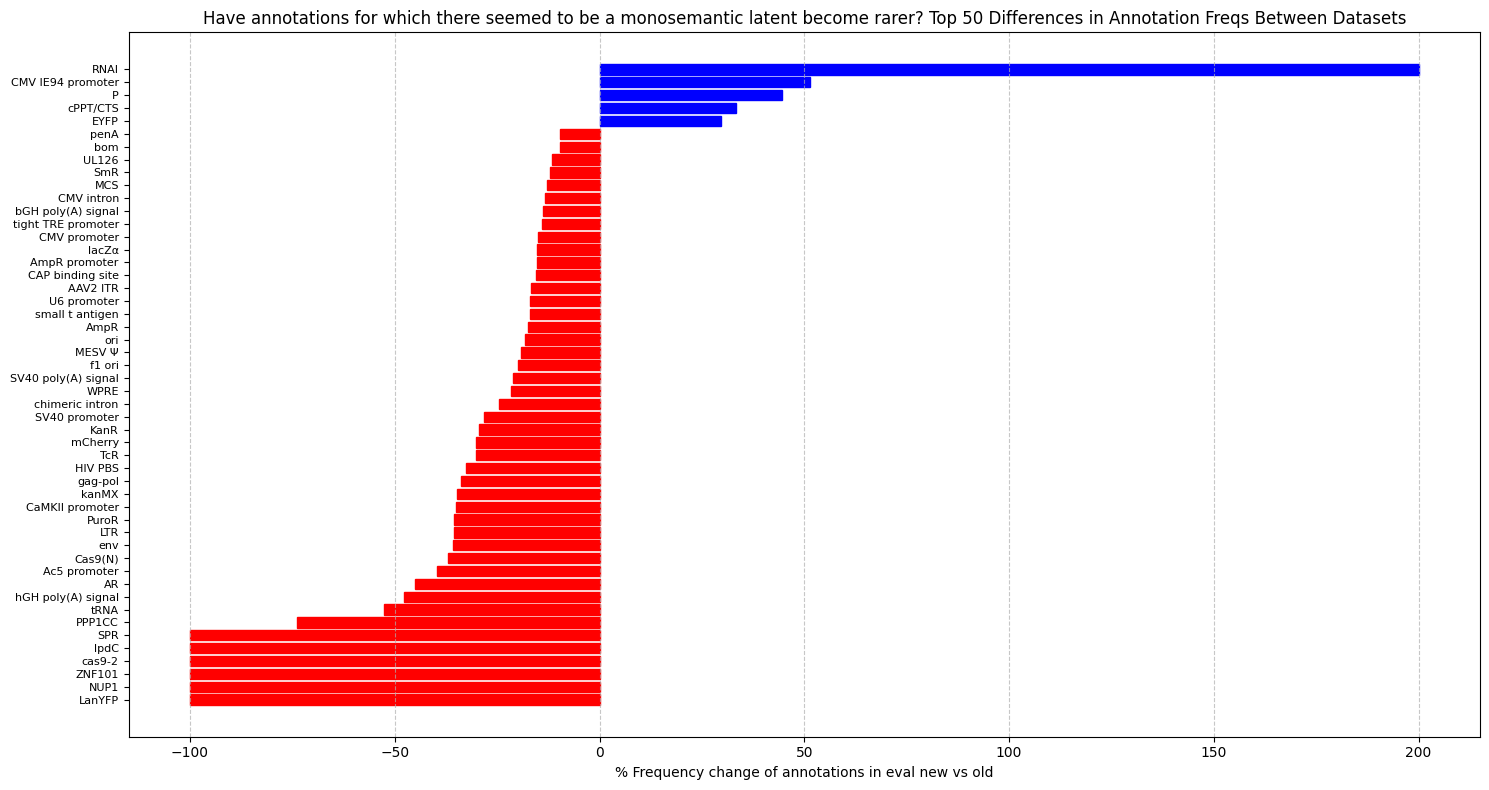


Top 20 differences (Dataset 2 - Dataset 1):
RNAI: 200
CMV IE94 promoter: 51
P: 44
cPPT/CTS: 33
EYFP: 29
penA: -9
bom: -9
UL126: -11
SmR: -12
MCS: -12
CMV intron: -13
bGH poly(A) signal: -13
tight TRE promoter: -14
CMV promoter: -14
lacZα: -15
AmpR promoter: -15
CAP binding site: -15
AAV2 ITR: -16
U6 promoter: -16
small t antigen: -16
AmpR: -17
ori: -18
MESV Ψ: -19
f1 ori: -19
SV40 poly(A) signal: -21
WPRE: -21
chimeric intron: -24
SV40 promoter: -28
KanR: -29
mCherry: -30
TcR: -30
HIV PBS: -32
gag-pol: -33
kanMX: -34
CaMKII promoter: -35
PuroR: -35
LTR: -35
env: -35
Cas9(N): -36
Ac5 promoter: -39
AR: -45
hGH poly(A) signal: -47
tRNA: -52
PPP1CC: -73
SPR: -100
lpdC: -100
cas9-2: -100
ZNF101: -100
NUP1: -100
LanYFP: -100


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create df differences from annotated_diff
df = pd.DataFrame(list(annotated_diff.items()), columns=['annotation', 'difference'])

# Sort by absolute difference and get top 20
top_20_diff = df['difference'].abs().nlargest(50)
df_plot = df.loc[top_20_diff.index].sort_values('difference', ascending=True)

# Create the plot with a wider figure
plt.figure(figsize=(15, 8))  # Increased width from 12 to 15

# Add more left margin for labels
plt.subplots_adjust(left=0.3)  # Add space for labels

# Create bars
bars = plt.barh(range(len(df_plot)), df_plot['difference'])

# Color bars based on positive/negative values
for i, bar in enumerate(bars):
    if bar.get_width() < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

# Use annotations for y-labels
plt.yticks(range(len(df_plot)), df_plot['annotation'], fontsize=8)
plt.xlabel('% Frequency change of annotations in eval new vs old')
plt.title('Have annotations for which there seemed to be a monosemantic latent become rarer? Top 50 Differences in Annotation Freqs Between Datasets')

plt.grid(axis='x', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

# Print the actual values
print("\nTop 20 differences (Dataset 2 - Dataset 1):")
for idx, row in df_plot[::-1].iterrows():
    print(f"{row['annotation']}: {int(row['difference'])}")

### Running SAE

Let's go and investigate a non rare feature.

We start by getting the SAE activations for (all) token in our dataset

In [ ]:
d_model = cfg["d_model"]
d_mlp = cfg["d_mlp"]
num_layer = 11
batch_size = 256

tokens = tokens_new

total_tokens = tokens['input_ids'].shape[0] * tokens['input_ids'].shape[1]
num_batches = (total_tokens + batch_size - 1) // batch_size

all_latents = []


sae_model.eval()
model_nt.eval()

for i in range(num_batches):
   start_idx = i * batch_size
   end_idx = min((i + 1) * batch_size, total_tokens)

   # Reshape tokens for current batch
   batch_input_ids = tokens['input_ids'][start_idx:end_idx].cuda()
   batch_attention_mask = tokens['attention_mask'][start_idx:end_idx].cuda()

   with torch.no_grad():
         # Get MLP activations
          mlp_act = utils.get_layer_activations(model_nt.cuda(), batch_input_ids, batch_attention_mask, layer_N=num_layer)
          mlp_act = mlp_act[0].reshape(-1, d_mlp)
          #all_acts.append(mlp_act)

          # Forward pass through SAE
          loss, x_reconstruct, latents, l2_loss, nmse, l1_loss, true_l0 = sae_model(mlp_act)
          all_latents.append(latents)

# Combine results, move to cpu before
all_latents = [x.cpu() for x in all_latents]
combined_latents_actually_old = torch.cat(all_latents, dim=0).cpu()
torch.cuda.empty_cache()

In [ ]:
latent_id = 393 # or set particular int value in range 0, 4095

# we avoid modifying token_df directly as its very time-consuming to reload if we mess it up
token_df_copy_old = token_df_new.copy()

# get the activation value for the N-th unit in the SAE for each input in batch
hidden_act_feature_id = combined_latents_actually_old[:, latent_id] # N = feature_id

# add this to the dataframe
token_df_copy_old[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

# sort to show the most activating tokens on top, add colours
token_df_copy_old.sort_values(f"latent-{latent_id}-act", ascending=False).head(20
                                                                           ).style.background_gradient("coolwarm")

,seq_id,token_pos,tokens,context,token_annotations,context_annotations,e-value annotation,percentage match,latent-393-act
41918,81,446,GTGCAC,AAGCTGGGCTGT |GTGCAC| GAACCCCCCGTT,"['ori', 'RNAI']","['ori', 'RNAI']",[0. 0.],[ 99.66 100. ],33.275345
1071477,2095,373,AAAGAA,AAGGCCAGGGGG |AAAGAA| AAAATATAAATT,[],[],[],[],31.454218
707446,1382,374,CCTGGC,GCCCGCGTGGTT |CCTGGC| CACCGTCGGAGT,['hRluc'],['hRluc'],[0.],[100.],31.157770
978289,1912,369,AGATAT,CATCGAGTCGGA |AGATAT| AGCACGAAAACT,[],[],[],[],30.669565
1488314,2914,442,CTGGCA,GACTTATCGCCA |CTGGCA| GCAGCCACTGGT,"['CmR', 'PDK intron']","['CmR', 'PDK intron']",[0. 0.],[100. 99.743],29.197325
473987,925,387,TCTCGC,GGTGCACAATCT |TCTCGC| GCAACGCGTCAG,[],[],[],[],24.464481
811865,1587,345,,||,['special token: '],[],nan,nan,24.374792
343915,671,363,GTCGGG,GCTCGCGATAAT |GTCGGG| CAATCAGGTGCG,"['AAC AAD leader', 'GmR']","['AAC AAD leader', 'GmR']",[0.00e+00 1.47e-20],[100. 96.491],23.957962
1149993,2249,41,ACTGGC,TCGTCCCCTCAA |ACTGGC| AGATGCACGGTT,['cas5d'],['cas5d'],[5.56e-88],[57.4],21.832113
1222820,2391,164,,||,['special token: '],[],nan,nan,20.033983


In [ ]:
latent_id = 393 # or set particular int value in range 0, 4095

# we avoid modifying token_df directly as its very time-consuming to reload if we mess it up
token_df_copy_old = token_df_old.copy()

# get the activation value for the N-th unit in the SAE for each input in batch
hidden_act_feature_id = combined_latents_actually_old[:, latent_id] # N = feature_id

# add this to the dataframe
token_df_copy_old[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

# sort to show the most activating tokens on top, add colours
token_df_copy_old.sort_values(f"latent-{latent_id}-act", ascending=False).head(20
                                                                           ).style.background_gradient("coolwarm")


,seq_id,token_pos,tokens,context,token_annotations,context_annotations,e-value annotation,percentage match,latent-393-act
74174,144,446,GCTCAC,GGCACAATCTTG |GCTCAC| TGCAATCTCCGC,"['hGH poly(A) signal', 'C9orf85']","['hGH poly(A) signal', 'C9orf85']",[0.00e+00 1.19e-22],[100. 75.9],33.275345
52597,102,373,GCTCAC,GGCACAATCTTG |GCTCAC| TGCAATCTCCGC,"['hGH poly(A) signal', 'C9orf85']","['hGH poly(A) signal', 'C9orf85']",[0.00e+00 2.31e-22],[100. 75.9],31.454218
1443702,2827,374,GCTCAC,GGCACAATCTTG |GCTCAC| TGCAATCTCCGC,"['hGH poly(A) signal', 'C9orf85']","['hGH poly(A) signal', 'C9orf85']",[0.00e+00 1.39e-22],[100. 75.9],31.157770
1186673,2323,369,GCTCAC,GGCACAATCTTG |GCTCAC| TGCAATCTCCGC,"['hGH poly(A) signal', 'C9orf85']","['hGH poly(A) signal', 'C9orf85']",[0.00e+00 1.58e-22],[100. 75.9],30.669565
1131450,2215,442,GCTCAC,GGCACAGTCTTG |GCTCAC| TGCAGCCTGGAC,['C9orf85'],['C9orf85'],[4.13e-06],[67.6],29.197325
1281923,2510,387,CTCACT,GCACAATCTTGG |CTCACT| GCAATCTCCGCC,"['hGH poly(A) signal', 'C9orf85']","['hGH poly(A) signal', 'C9orf85']",[0.00e+00 2.07e-22],[100. 75.9],24.464481
500057,978,345,CTCACT,GCACAATCTTGG |CTCACT| GCAATCTCCGCC,"['hGH poly(A) signal', 'C9orf85']","['hGH poly(A) signal', 'C9orf85']",[0.00e+00 1.35e-22],[100. 75.9],24.374792
119659,234,363,CTCACT,GCACAATCTTGG |CTCACT| GCAATCTCCGCC,"['hGH poly(A) signal', 'C9orf85']","['hGH poly(A) signal', 'C9orf85']",[0.00e+00 9.73e-23],[100. 75.9],23.957962
989225,1937,41,CTCACT,GCGTAATCTCGG |CTCACT| ACAACCTCCACC,['C9orf85'],['C9orf85'],[5.14e-23],[72.7],21.832113
854692,1672,164,CTCACT,TTGCGATCTTGG |CTCACT| GCAACCTCTGCC,['GVQW1'],['GVQW1'],[3.49e-24],[57.3],20.033983


We can now sort and display the top tokens that activate the hidden SAE unit


In [ ]:
latent_id = 393 # or set particular int value in range 0, 4095

# we avoid modifying token_df directly as its very time-consuming to reload if we mess it up
token_df_copy = token_df_new.copy()

# get the activation value for the N-th unit in the SAE for each input in batch
hidden_act_feature_id = combined_latents_old[:, latent_id] # N = feature_id

# add this to the dataframe
token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

# sort to show the most activating tokens on top, add colours
token_df_copy.sort_values(f"latent-{latent_id}-act", ascending=False).head(60
                                                                           ).style.background_gradient("coolwarm")


,seq_id,token_pos,tokens,context,token_annotations,context_annotations,e-value annotation,percentage match,latent-393-act
313790,612,446,GCAGTT,CTAGAACGATTC |GCAGTT| AATCCTGGCCTG,['NMNAT3'],['NMNAT3'],[1.69e-198],[72.8],33.275345
81781,159,373,AGCAAG,TTCCTCTACGGC |AGCAAG| ACCTTCATCAAC,[],[],[],[],31.454218
811382,1586,374,TGCCAC,ACTTTACATCTG |TGCCAC| TGGAAGGAAGTG,[],[],[],[],31.157770
1516913,2970,369,,||,['special token: '],[],nan,nan,30.669565
72634,141,442,GCGACC,CACTGAGGCCGG |GCGACC| AAAGGTCGCCCG,[],[],[],[],29.197325
590723,1154,387,CCAACT,GATCAAGAGCTA |CCAACT| CTTTTTCCGAAG,['ACTR3'],['ACTR3'],[0.],[100.],24.464481
499545,976,345,,||,['special token: '],[],nan,nan,24.374792
233323,455,363,GCGGCC,TTGATCGACTGC |GCGGCC| TTCGGCCTTGCC,[],[],[],[],23.957962
44073,86,41,CTCGGA,CGATGTCTTCGA |CTCGGA| GACGCACAACCG,['Fmn1'],['Fmn1'],[8.1e-184],[99.6],21.832113
435876,851,164,,||,['special token: '],['Superfolder GFP'],nan,nan,20.033983


### Run SAE on synthetic sequences

In [ ]:
# create synthetic sequence by taking random seq and inserting string
insert = "GTTTTA"*100

seq = df_val['sequence'].iloc[633]
start_idx = np.random.randint(0, len(seq) - len(insert))
end_idx = start_idx + len(insert)

syn_seq = seq[:start_idx] + insert + seq[end_idx:]

tokens = tokenizer_nt(syn_seq, max_length=512, padding='max_length', truncation=True, return_tensors="pt")

with torch.no_grad():
    # Get MLP activations
    mlp_act = utils.get_layer_activations(model_nt, tokens['input_ids'].cuda(), tokens['attention_mask'].cuda())
    mlp_act = mlp_act[0] # unnest
    mlp_act = mlp_act.reshape(-1, d_mlp)

    # Forward pass with SAE
    loss, x_reconstruct, latents, l2_loss, nmse, l1_loss, true_l0 = sae_model(mlp_act)
    combined_latents = latents.cpu()






In [ ]:
latent_id = 73 # or set particular int value in range 0, 4095

# create dataframe with 512 rows, each containing one of the tokens
tokens_str = tokenizer_nt.convert_ids_to_tokens(tokens['input_ids'][0])
token_df_minimal = pd.DataFrame({'tokens': tokens_str})


# get the activation value for the N-th unit in the SAE for each input in batch
hidden_act_feature_id = combined_latents[:, latent_id] # N = feature_id

# add this to the dataframe
token_df_minimal[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

# sort to show the most activating tokens on top, add colours
token_df_minimal.sort_values(f"latent-{latent_id}-act", ascending=False).head(30).style.background_gradient("coolwarm")


,tokens,latent-73-act
103,GTTTTA,18.000984
82,AGTTTT,11.520086
350,GACCAC,0.000000
349,GGTCTG,0.000000
348,CGTGGC,0.000000
347,CGCCGC,0.000000
346,CGACGG,0.000000
345,CGCGGA,0.000000
344,GTGGGT,0.000000
343,CAAGGT,0.000000


## Auto-searching monosemantic latents

1. Searching *functional* SAE Latents

In [ ]:
def safe_get_annotations(ann_entry):
    if isinstance(ann_entry, str):
        try:
            return eval(ann_entry)
        except:
            return []
    return ann_entry  # already a list

N_latents = 4096
latent_dict = {}
# Then modify the analysis:
for latent_id in range(N_latents):
    hidden_act_feature_id = combined_latents_old[:, latent_id]
    token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

    most_activating_tokens = token_df_copy.sort_values(f"latent-{latent_id}-act", ascending=False).head(20)

    # Skip if any activations are 0
    if (most_activating_tokens[f"latent-{latent_id}-act"] == 0).any():
        continue

    annotations = [safe_get_annotations(ann) for ann in most_activating_tokens['token_annotations']]

    if annotations:
        annotation_counts = {}
        for ann_list in annotations:
            for ann in ann_list:
                annotation_counts[ann] = annotation_counts.get(ann, 0) + 1

        common_annotations = {ann for ann, count in annotation_counts.items()
                            if count >= 10 and ann not in {'special token: <cls>', 'special token: <pad>'}}

        if common_annotations:
            latent_dict[latent_id] = common_annotations
            print(f"\nLatent {latent_id} appears to detect: {common_annotations}")
            print("Top 20 activating tokens and their annotations:")
            for _, row in most_activating_tokens.iterrows():
                print(f"Token: {row['tokens']}, Annotations: {safe_get_annotations(row['token_annotations'])}, "
                      f"Activation: {row[f'latent-{latent_id}-act']:.3f}")


Latent 22 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: CTCCGC, Annotations: ['C9orf85'], Activation: 18.726
Token: CTCCGC, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 18.590
Token: CTCCGC, Annotations: ['AR'], Activation: 18.153
Token: CTCCGC, Annotations: ['C9orf85', 'large T antigen'], Activation: 17.767
Token: TCCGCC, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 17.682
Token: GACCTC, Annotations: [], Activation: 17.680
Token: TGCAGC, Annotations: ['mvaS', 'C9orf85'], Activation: 16.847
Token: TCTCCG, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 16.507
Token: TCCGCC, Annotations: ['cat', 'PDK intron'], Activation: 16.250
Token: TCCGCC, Annotations: ['BRL1'], Activation: 16.158
Token: TTTACC, Annotations: ['C9orf85'], Activation: 15.866
Token: TCTCCG, Annotations: ['SV40 ori', 'C9orf85', 'SELP_SV40'], Activation: 15.640
Token: TCTCCG, Annotations: ['hGH poly(A) signal'], Activation: 15.124
Token: T

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 276 appears to detect: {'AmpR'}
Top 20 activating tokens and their annotations:
Token: CTTACC, Annotations: ['AmpR', 'f1 ori'], Activation: 10.255
Token: CTTACC, Annotations: ['AmpR'], Activation: 10.095
Token: CTTACC, Annotations: ['Dendra2', 'AmpR'], Activation: 10.010
Token: CTTACC, Annotations: [], Activation: 9.988
Token: CTTACC, Annotations: ['NeoR/KanR'], Activation: 9.987
Token: CTTACC, Annotations: ['AmpR'], Activation: 9.979
Token: CTTACC, Annotations: ['AmpR'], Activation: 9.928
Token: CTTACC, Annotations: ['AmpR'], Activation: 9.912
Token: CTTACC, Annotations: [], Activation: 9.881
Token: CTTACC, Annotations: ['AmpR', 'FBXW5'], Activation: 9.859
Token: CTTACC, Annotations: [], Activation: 9.844
Token: CTTACC, Annotations: ['f1 ori', 'AmpR'], Activation: 9.836
Token: CTTACC, Annotations: [], Activation: 9.796
Token: CTTACC, Annotations: [], Activation: 9.783
Token: CTTACC, Annotations: [], Activation: 9.779
Token: CTTACC, Annotations: [], Activation: 9.761
Token: CTT

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 316 appears to detect: {'ori'}
Top 20 activating tokens and their annotations:
Token: GCCACC, Annotations: ['ori'], Activation: 14.685
Token: GCCACC, Annotations: [], Activation: 14.663
Token: GCCACC, Annotations: [], Activation: 14.396
Token: GCCACC, Annotations: ['P', 'ori', 'WPRE'], Activation: 14.366
Token: GCCACC, Annotations: [], Activation: 14.282
Token: GCCACC, Annotations: [], Activation: 14.190
Token: GCCACC, Annotations: [], Activation: 14.089
Token: GCCACC, Annotations: ['FLPo'], Activation: 13.959
Token: GCCACC, Annotations: ['gag'], Activation: 13.926
Token: GCCACC, Annotations: ['ori'], Activation: 13.902
Token: GCCACC, Annotations: ['ori'], Activation: 13.893
Token: GCCACC, Annotations: ['ori'], Activation: 13.883
Token: GCCACC, Annotations: ['KRT18'], Activation: 13.871
Token: GCCACC, Annotations: ['LEU2', 'ori'], Activation: 13.865
Token: GCCACC, Annotations: ['ori'], Activation: 13.813
Token: GCCACC, Annotations: ['ori'], Activation: 13.590
Token: GCCACC, Ann

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 361 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: CGATTC, Annotations: ['hGH poly(A) signal'], Activation: 20.952
Token: CGTTTC, Annotations: ['RNF8'], Activation: 20.134
Token: CGATTC, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 19.683
Token: CGATTC, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 19.496
Token: GGTTCA, Annotations: ['AR'], Activation: 11.039
Token: TTCTCC, Annotations: ['hGH poly(A) signal'], Activation: 10.756
Token: GGTTCA, Annotations: ['C9orf85', 'large T antigen'], Activation: 10.584
Token: TTCTCC, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 10.527
Token: TTCTCC, Annotations: ['SV40 ori', 'C9orf85', 'SELP_SV40'], Activation: 10.131
Token: GGTTCA, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 10.087
Token: GGTTCA, Annotations: ['C9orf85'], Activation: 10.020
Token: GATTCT, Annotations: [], Activation: 10.009
Token: TGATCT, Annotations: ['hGH poly(A) signal'], 

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 393 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: GCTCAC, Annotations: ['C9orf85'], Activation: 33.275
Token: GCTCAC, Annotations: ['C9orf85'], Activation: 31.454
Token: GCTCAC, Annotations: ['AR'], Activation: 31.158
Token: GCTCAC, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 30.670
Token: GCTCAC, Annotations: ['mvaS', 'C9orf85'], Activation: 29.197
Token: CTCACT, Annotations: ['BRL1'], Activation: 24.464
Token: CTCACT, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 24.375
Token: CTCACT, Annotations: ['cat', 'PDK intron'], Activation: 23.958
Token: CTCACT, Annotations: ['C9orf85', 'int'], Activation: 21.832
Token: CTCACT, Annotations: [], Activation: 20.034
Token: CTCACT, Annotations: ['ori'], Activation: 18.682
Token: CTTACT, Annotations: ['C9orf85'], Activation: 17.025
Token: GGCTCA, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 12.379
Token: TCACTG, Annotations: ['C9orf85', 'hGH poly(A) signal

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 411 appears to detect: {'PuroR'}
Top 20 activating tokens and their annotations:
Token: CGCGCA, Annotations: ['PuroR'], Activation: 11.539
Token: CGCGCA, Annotations: [], Activation: 11.528
Token: CGCGCA, Annotations: ['PuroR'], Activation: 11.527
Token: CGCGCA, Annotations: ['PuroR'], Activation: 11.524
Token: CGCGCA, Annotations: ['CMV intron', 'PuroR', 'T7 promoter'], Activation: 11.523
Token: CGCGCA, Annotations: [], Activation: 11.522
Token: CGCGCA, Annotations: [], Activation: 11.522
Token: CGCGCA, Annotations: ['PuroR'], Activation: 11.522
Token: CGCGCA, Annotations: ['TIAM1', 'PuroR'], Activation: 11.520
Token: CGCGCA, Annotations: ['PuroR'], Activation: 11.517
Token: CGCGCA, Annotations: ['GFPmut3'], Activation: 11.514
Token: CGCGCA, Annotations: ['λ tL3 terminator'], Activation: 11.505
Token: CGCGCA, Annotations: ['PuroR', 'ori'], Activation: 11.504
Token: CGCGCA, Annotations: [], Activation: 11.501
Token: CGCGCA, Annotations: ['PuroR'], Activation: 11.479
Token: CGCG

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 429 appears to detect: {'AmpR'}
Top 20 activating tokens and their annotations:
Token: ATAGTT, Annotations: ['DCLK1'], Activation: 11.840
Token: ATAGTT, Annotations: ['AmpR', 'R1A_SARS2'], Activation: 11.668
Token: ATAGTT, Annotations: [], Activation: 11.378
Token: ATAGTT, Annotations: ['AmpR', 'PuroR'], Activation: 11.332
Token: ATAGTT, Annotations: [], Activation: 11.247
Token: ATAGTT, Annotations: [], Activation: 11.199
Token: ATAGTT, Annotations: ['AmpR'], Activation: 11.173
Token: ATAGTT, Annotations: ['AmpR'], Activation: 11.136
Token: ATAGTT, Annotations: ['bom'], Activation: 11.076
Token: ATAGTT, Annotations: [], Activation: 11.057
Token: ATAGTT, Annotations: ['cyp102A1', 'AmpR'], Activation: 10.992
Token: ATAGTT, Annotations: ['AmpR', 'PuroR'], Activation: 10.971
Token: ATAGTT, Annotations: ['AmpR'], Activation: 10.969
Token: ATAGTT, Annotations: ['AmpR'], Activation: 10.861
Token: ATAGTT, Annotations: ['bla(M)'], Activation: 10.852
Token: ATAGTT, Annotations: ['AmpR']

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 454 appears to detect: {'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: AGGGAC, Annotations: ['CMV enhancer', 'CMV promoter'], Activation: 11.041
Token: AGGGAC, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 11.004
Token: AGGGAC, Annotations: ['CMV enhancer', 'CMV promoter'], Activation: 10.404
Token: AGGGAC, Annotations: ['CMV promoter'], Activation: 10.136
Token: AGGGAC, Annotations: ['CMV enhancer'], Activation: 10.053
Token: AGGGAC, Annotations: ['CMV promoter', 'SRα promoter', "5' LTR (truncated)", 'CMV enhancer'], Activation: 10.039
Token: AGGGAC, Annotations: ['CMV enhancer'], Activation: 9.988
Token: AGGGAC, Annotations: [], Activation: 9.948
Token: AGGGAC, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 9.934
Token: AGGGAC, Annotations: ['CMV promoter'], Activation: 9.929
Token: AGGGAC, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 9.852
Token: AGGGAC, Annotations: ['CMV enhancer'], Activation: 9.829
Token: AGG

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 500 appears to detect: {'AmpR'}
Top 20 activating tokens and their annotations:
Token: <cls>, Annotations: ['special token: <cls>'], Activation: 30.305
Token: <cls>, Annotations: ['special token: <cls>'], Activation: 28.695
Token: CTCTTG, Annotations: ['AmpR'], Activation: 23.564
Token: GTTTAC, Annotations: [], Activation: 22.006
Token: <cls>, Annotations: ['special token: <cls>'], Activation: 21.923
Token: CTTTTC, Annotations: ['AmpR'], Activation: 21.514
Token: ACGGGA, Annotations: ['AmpR'], Activation: 17.947
Token: GCTGTT, Annotations: ['AmpR'], Activation: 17.824
Token: TTCGGG, Annotations: ['AmpR'], Activation: 17.594
Token: CTGAGA, Annotations: ['AmpR'], Activation: 17.370
Token: GCTAAG, Annotations: ['bGH poly(A) signal'], Activation: 17.322
Token: CATTAG, Annotations: ['CHRM4'], Activation: 17.143
Token: <pad>, Annotations: ['special token: <pad>'], Activation: 16.998
Token: GATATA, Annotations: ['CFP'], Activation: 16.979
Token: GCGACC, Annotations: ['AmpR'], Activati

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 506 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: TGCAAT, Annotations: ['C9orf85'], Activation: 18.589
Token: TGCAAT, Annotations: ['AR'], Activation: 17.683
Token: TGCAAT, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 16.740
Token: TGCAAT, Annotations: ['C9orf85', 'large T antigen'], Activation: 16.563
Token: TGCAGC, Annotations: ['mvaS', 'C9orf85'], Activation: 13.327
Token: CTGGAC, Annotations: ['mvaS', 'C9orf85'], Activation: 3.391
Token: GCAACC, Annotations: [], Activation: 2.913
Token: TGCAAT, Annotations: ['ori', 'C9orf85'], Activation: 2.786
Token: CGTAAT, Annotations: ['RNF8'], Activation: 2.687
Token: CACAAT, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 1.950
Token: TCTCCG, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 1.636
Token: CACAAT, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 1.569
Token: CTGCAA, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 1.285
To

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 806 appears to detect: {'SV40 promoter'}
Top 20 activating tokens and their annotations:
Token: TATGCA, Annotations: ['SV40 promoter', 'AR'], Activation: 14.370
Token: ATGCAA, Annotations: ['SV40 promoter'], Activation: 13.521
Token: TATGCA, Annotations: [], Activation: 13.411
Token: ATGCAA, Annotations: ['SV40 promoter', 'PDK intron'], Activation: 13.347
Token: ATGCAA, Annotations: ['SV40 promoter'], Activation: 13.342
Token: ATGCAA, Annotations: ['WPRE', 'SV40 promoter', 'P'], Activation: 13.137
Token: ATGCAA, Annotations: [], Activation: 13.131
Token: TATGCA, Annotations: ['SV40 promoter', 'ZNF571'], Activation: 13.055
Token: TATGCA, Annotations: [], Activation: 13.024
Token: ATGCAA, Annotations: [], Activation: 12.998
Token: TATGCA, Annotations: ['SV40 promoter'], Activation: 12.887
Token: TATGCA, Annotations: ['SV40 promoter', 'AmpR promoter'], Activation: 12.867
Token: ATGCAA, Annotations: ['WPRE', 'SV40 promoter', 'P'], Activation: 12.853
Token: ATGCAA, Annotations: ['SV

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 829 appears to detect: {'AR'}
Top 20 activating tokens and their annotations:
Token: CATCAT, Annotations: [], Activation: 21.132
Token: CATCAT, Annotations: [], Activation: 20.720
Token: CCACCA, Annotations: [], Activation: 20.591
Token: ATCATC, Annotations: [], Activation: 20.589
Token: CAGCAG, Annotations: ['AR'], Activation: 19.951
Token: GCAGCA, Annotations: ['AR'], Activation: 19.941
Token: GCAGCA, Annotations: ['AR'], Activation: 19.822
Token: GCAGCA, Annotations: ['AR'], Activation: 19.773
Token: CAGCAG, Annotations: ['AR'], Activation: 19.750
Token: CATCAT, Annotations: [], Activation: 19.700
Token: GCAGCA, Annotations: ['AR', 'tdTomato'], Activation: 19.694
Token: CATCAT, Annotations: ['capTEV™'], Activation: 19.675
Token: GCAGCA, Annotations: ['AR', 'tdTomato'], Activation: 19.632
Token: CAGCAG, Annotations: ['AR'], Activation: 19.619
Token: CAGCAG, Annotations: ['AR'], Activation: 19.596
Token: GCAGCA, Annotations: ['AR'], Activation: 19.566
Token: GCAGCA, Annotation

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 856 appears to detect: {'TERF2'}
Top 20 activating tokens and their annotations:
Token: AAAAAA, Annotations: [], Activation: 22.745
Token: AAAAAA, Annotations: [], Activation: 21.794
Token: AAAAAA, Annotations: ['purD'], Activation: 19.611
Token: AAAAAA, Annotations: [], Activation: 19.396
Token: AAAAAA, Annotations: [], Activation: 18.815
Token: AAAAAA, Annotations: [], Activation: 18.685
Token: AAAAAA, Annotations: [], Activation: 18.574
Token: AAAAAA, Annotations: [], Activation: 18.460
Token: AAAAAA, Annotations: ['TERF2'], Activation: 18.399
Token: AAAAAA, Annotations: ['purD'], Activation: 18.296
Token: AAAAAA, Annotations: ['TERF2'], Activation: 18.229
Token: AAAAAA, Annotations: ['TERF2'], Activation: 17.744
Token: AAAAAA, Annotations: ['TERF2'], Activation: 17.597
Token: AAAAAA, Annotations: ['TERF2'], Activation: 17.443
Token: AAAAAA, Annotations: ['TERF2'], Activation: 17.339
Token: AAAAAA, Annotations: [], Activation: 17.208
Token: AAAAAA, Annotations: ['TERF2'], Ac

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 877 appears to detect: {'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: GGCAGT, Annotations: ['CMV enhancer'], Activation: 19.949
Token: GGCAGT, Annotations: ['CMV enhancer'], Activation: 19.835
Token: GGCAGT, Annotations: ['pheT', 'CMV enhancer'], Activation: 19.607
Token: GGCAGT, Annotations: ['CMV enhancer'], Activation: 19.438
Token: GGCAGT, Annotations: ['TLX3'], Activation: 19.413
Token: GGCAGT, Annotations: [], Activation: 19.334
Token: GGCAGT, Annotations: ['CMV enhancer'], Activation: 19.312
Token: GGCAGT, Annotations: ['CMV enhancer'], Activation: 19.266
Token: GGCAGT, Annotations: [], Activation: 19.244
Token: GGCAGT, Annotations: ['CMV enhancer'], Activation: 19.206
Token: GGCAGT, Annotations: ['CMV enhancer'], Activation: 19.185
Token: GGCAGT, Annotations: [], Activation: 19.178
Token: GGCAGT, Annotations: ['int'], Activation: 19.176
Token: GGCAGT, Annotations: ['kanMX', 'CMV enhancer'], Activation: 19.166
Token: GGCAGT, Annotations: ['CMV en

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 928 appears to detect: {'hGH poly(A) signal'}
Top 20 activating tokens and their annotations:
Token: CATGCA, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 21.722
Token: CATGCA, Annotations: ['hGH poly(A) signal'], Activation: 21.270
Token: CATGCA, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 20.905
Token: CGTGAA, Annotations: ['hGH poly(A) signal'], Activation: 16.952
Token: CGTGAA, Annotations: ['hGH poly(A) signal'], Activation: 16.521
Token: CGTGAA, Annotations: [], Activation: 16.411
Token: CATGAG, Annotations: [], Activation: 15.051
Token: CGCCTG, Annotations: ['RNF8'], Activation: 14.627
Token: TGCATG, Annotations: ['S'], Activation: 12.007
Token: TGTGAG, Annotations: [], Activation: 9.384
Token: GTTTCA, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 6.140
Token: CACAAT, Annotations: ['hGH poly(A) signal'], Activation: 5.713
Token: GTTTCA, Annotations: ['hGH poly(A) signal'], Activation: 5.351
Token: CGTAAT, Annotations: ['RNF8'],

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 947 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: AGCGAT, Annotations: ['AR'], Activation: 28.338
Token: AGCGAT, Annotations: ['C9orf85', 'large T antigen'], Activation: 28.171
Token: AGCGAT, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 27.591
Token: AGCGAT, Annotations: ['C9orf85'], Activation: 26.930
Token: AGCCAT, Annotations: ['mvaS', 'C9orf85'], Activation: 25.139
Token: AAGCGA, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 18.282
Token: AAGCGA, Annotations: ['SV40 ori', 'C9orf85', 'SELP_SV40'], Activation: 18.093
Token: AAATGA, Annotations: ['S'], Activation: 18.075
Token: AAGCGA, Annotations: ['hGH poly(A) signal'], Activation: 17.432
Token: AGTGAT, Annotations: [], Activation: 16.049
Token: GCGTTT, Annotations: ['C9orf85', 'int'], Activation: 12.545
Token: GCGATT, Annotations: [], Activation: 11.692
Token: CGTTTC, Annotations: ['RNF8'], Activation: 11.636
Token: CGATTC, Annotations: ['hGH poly(A) signa

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 957 appears to detect: {'SmR'}
Top 20 activating tokens and their annotations:
Token: ACATCA, Annotations: ['SmR'], Activation: 21.902
Token: ACATCA, Annotations: ['SmR'], Activation: 20.891
Token: ACATCA, Annotations: [], Activation: 20.084
Token: ACATCA, Annotations: ['SmR'], Activation: 19.871
Token: ACATCA, Annotations: [], Activation: 19.649
Token: ACATCA, Annotations: ['SmR'], Activation: 19.639
Token: ACATCA, Annotations: [], Activation: 19.484
Token: ACATCA, Annotations: [], Activation: 19.204
Token: ACATCA, Annotations: ['SmR'], Activation: 17.735
Token: ACATCA, Annotations: ['aadA', 'RT86_ECOLX'], Activation: 16.330
Token: ACATCA, Annotations: [], Activation: 16.312
Token: ACATCA, Annotations: ['SmR'], Activation: 15.441
Token: AAGTCA, Annotations: ['SmR'], Activation: 13.295
Token: AAGTCA, Annotations: ['SmR'], Activation: 13.064
Token: AAGTCA, Annotations: [], Activation: 12.631
Token: AAGTCA, Annotations: ['SmR'], Activation: 12.411
Token: AAGTCA, Annotations: ['Sm

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()



Latent 958 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: AGCCAT, Annotations: ['mvaS', 'C9orf85'], Activation: 16.547
Token: GCGATT, Annotations: ['C9orf85'], Activation: 16.460
Token: GCGATT, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 15.153
Token: GCGATT, Annotations: [], Activation: 14.820
Token: GCGATT, Annotations: ['BRL1'], Activation: 14.430
Token: AGCGAT, Annotations: ['C9orf85', 'large T antigen'], Activation: 14.204
Token: AGCGAT, Annotations: ['AR'], Activation: 13.783
Token: GCGATT, Annotations: ['cat', 'PDK intron'], Activation: 13.763
Token: AGCGAT, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 13.479
Token: GCCATT, Annotations: ['ori'], Activation: 13.300
Token: AGCGAT, Annotations: ['C9orf85'], Activation: 13.247
Token: GCGTTT, Annotations: ['C9orf85', 'int'], Activation: 12.816
Token: TCCTGC, Annotations: ['hGH poly(A) signal'], Activation: 12.579
Token: TCCTGC, Annotations: ['RNF8'], Activation: 1

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 967 appears to detect: {'CMV IE94 promoter'}
Top 20 activating tokens and their annotations:
Token: CGTCAA, Annotations: ['DNApol-gamma35', 'CMV enhancer', 'CMV IE94 promoter'], Activation: 18.904
Token: CGTCAA, Annotations: [], Activation: 18.764
Token: CGTCAA, Annotations: ['lldR'], Activation: 18.715
Token: CGTCAA, Annotations: ['Act5C', 'CMV IE94 promoter'], Activation: 18.459
Token: CGTCAA, Annotations: ['CMV IE94 promoter'], Activation: 18.389
Token: CGTCAA, Annotations: ['Superfolder GFP'], Activation: 18.286
Token: CGTCAA, Annotations: ['CMV IE94 promoter', 'SV2C'], Activation: 18.161
Token: CGTCAA, Annotations: ['CMV IE94 promoter', 'CMV enhancer'], Activation: 18.120
Token: CGTCAA, Annotations: [], Activation: 18.085
Token: CGTCAA, Annotations: ['lacZ'], Activation: 18.084
Token: CGTCAA, Annotations: ['ZNF470'], Activation: 18.018
Token: CGTCAA, Annotations: ['CMV IE94 promoter', 'EGFP'], Activation: 17.996
Token: CGTCAA, Annotations: [], Activation: 17.974
Token: CGT

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1025 appears to detect: {'CMV IE94 promoter', 'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: CCCTAT, Annotations: [], Activation: 12.529
Token: CCCTAT, Annotations: [], Activation: 12.265
Token: CCCTAT, Annotations: ['CMV IE94 promoter', 'CMV enhancer'], Activation: 12.194
Token: CCCTAT, Annotations: ['mClover3'], Activation: 12.127
Token: CCCTAT, Annotations: [], Activation: 12.123
Token: CCCTAT, Annotations: ['CMV enhancer'], Activation: 12.062
Token: CCCTAT, Annotations: ['SUP35', 'CMV IE94 promoter'], Activation: 11.948
Token: CCCTAT, Annotations: ['E', 'CMV enhancer'], Activation: 11.860
Token: CCCTAT, Annotations: ['CMV enhancer', 'CMV IE94 promoter'], Activation: 11.843
Token: CCCTAT, Annotations: ['CMV enhancer', 'gag-pol'], Activation: 11.802
Token: CCCTAT, Annotations: ['avrXa10'], Activation: 11.797
Token: CCCTAT, Annotations: ['CMV enhancer'], Activation: 11.607
Token: CCCTAT, Annotations: ['CMV IE94 promoter'], Activation: 11.568
Token: CCCT

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1094 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: GGCACA, Annotations: ['C9orf85'], Activation: 21.211
Token: GGCACA, Annotations: ['C9orf85'], Activation: 20.257
Token: GGCACA, Annotations: ['AR'], Activation: 18.951
Token: GGCACA, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 18.857
Token: GGCACA, Annotations: ['mvaS', 'C9orf85'], Activation: 16.686
Token: GCACAA, Annotations: ['BRL1'], Activation: 14.821
Token: GCACAA, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 14.625
Token: GCACAA, Annotations: ['cat', 'PDK intron'], Activation: 14.317
Token: GCGTAA, Annotations: ['C9orf85', 'int'], Activation: 13.207
Token: GCGCGA, Annotations: ['ori'], Activation: 11.780
Token: TTGCGA, Annotations: [], Activation: 10.483
Token: GGGCAA, Annotations: ['C9orf85'], Activation: 9.985
Token: GCTCAC, Annotations: ['C9orf85'], Activation: 9.713
Token: GCTCAC, Annotations: ['C9orf85'], Activation: 9.466
Token: GCTCAC, Annotati

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1126 appears to detect: {'MTOR'}
Top 20 activating tokens and their annotations:
Token: T, Annotations: ['P'], Activation: 13.204
Token: N, Annotations: ['MTOR'], Activation: 13.023
Token: N, Annotations: ['attL2'], Activation: 12.826
Token: N, Annotations: ['MTOR'], Activation: 12.692
Token: T, Annotations: [], Activation: 12.560
Token: T, Annotations: ['MTOR'], Activation: 12.529
Token: T, Annotations: ['MTOR'], Activation: 12.495
Token: T, Annotations: [], Activation: 12.361
Token: N, Annotations: ['MTOR', 'lacZ'], Activation: 12.320
Token: <cls>, Annotations: ['special token: <cls>'], Activation: 12.271
Token: N, Annotations: [], Activation: 12.152
Token: N, Annotations: ['MTOR'], Activation: 12.144
Token: G, Annotations: ['attL2'], Activation: 12.139
Token: T, Annotations: ['MTOR'], Activation: 12.106
Token: T, Annotations: ['MTOR', 'trpS'], Activation: 12.080
Token: N, Annotations: ['MTOR', 'trpS'], Activation: 12.037
Token: N, Annotations: ['P'], Activation: 12.013
Token

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1133 appears to detect: {'C9orf85'}
Top 20 activating tokens and their annotations:
Token: GTGCAG, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 15.567
Token: GCACAA, Annotations: ['hGH poly(A) signal', 'C9orf85'], Activation: 15.433
Token: GCACAA, Annotations: ['BRL1'], Activation: 14.746
Token: GCACAA, Annotations: ['cat', 'PDK intron'], Activation: 14.632
Token: GTGCAG, Annotations: ['hGH poly(A) signal'], Activation: 13.317
Token: GTGCAG, Annotations: ['SV40 ori', 'C9orf85'], Activation: 13.070
Token: GCGTAA, Annotations: ['C9orf85', 'int'], Activation: 12.093
Token: GTGCAG, Annotations: ['S'], Activation: 10.924
Token: CAGTGG, Annotations: ['RNF8'], Activation: 10.112
Token: CAGTGG, Annotations: ['hGH poly(A) signal'], Activation: 9.854
Token: CAGTGG, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 9.719
Token: CAGTGG, Annotations: ['C9orf85', 'hGH poly(A) signal'], Activation: 9.589
Token: CTGGAG, Annotations: ['AR'], Activation: 9.055
Token: CTG

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1136 appears to detect: {'AmpR promoter'}
Top 20 activating tokens and their annotations:
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 12.301
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 12.170
Token: GCGGAA, Annotations: [], Activation: 12.039
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 11.839
Token: GCGGAA, Annotations: ['AmpR promoter', 'GST26_SCHJA'], Activation: 11.746
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 11.716
Token: GCGGAA, Annotations: ['f1 ori'], Activation: 11.535
Token: GCGGAA, Annotations: ['AmpR promoter', 'gag (truncated)'], Activation: 11.504
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 11.484
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 11.467
Token: GCGGAA, Annotations: ['AmpR promoter', 'env'], Activation: 11.444
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 11.166
Token: GCGGAA, Annotations: ['AmpR promoter'], Activation: 11.147
Token: GCGGAA, Annotation

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1144 appears to detect: {'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: GATTAT, Annotations: ['MCS', 'CMV enhancer'], Activation: 14.661
Token: GATTAT, Annotations: ['penA', 'lacI', 'CMV enhancer'], Activation: 14.593
Token: ATTGAC, Annotations: ['mTurquoise2', 'CMV enhancer'], Activation: 14.027
Token: GATTAT, Annotations: ['CMV enhancer'], Activation: 13.693
Token: GATTAT, Annotations: ['CMV enhancer'], Activation: 13.496
Token: GATTAT, Annotations: ['CMV enhancer', 'PRCC'], Activation: 13.424
Token: GATTAT, Annotations: ['CMV enhancer', 'CMV intron'], Activation: 13.423
Token: GATTAT, Annotations: ['CMV enhancer'], Activation: 13.390
Token: GATTAT, Annotations: ['lacI'], Activation: 13.350
Token: GATTAT, Annotations: ['CMV enhancer'], Activation: 13.173
Token: GATTAT, Annotations: ['TEF1 promoter'], Activation: 13.037
Token: GATTAT, Annotations: ['3xHA'], Activation: 12.998
Token: GATTAT, Annotations: ['CMV enhancer', 'CAP binding site'], Activation: 

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1182 appears to detect: {'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: CATTGA, Annotations: ['YPet', 'CMV enhancer'], Activation: 22.274
Token: CATTGA, Annotations: ['CMV enhancer'], Activation: 22.221
Token: CATTGA, Annotations: ['CMV enhancer', 'Tln1'], Activation: 22.152
Token: CATTGA, Annotations: [], Activation: 22.078
Token: CATTGA, Annotations: ['CMV enhancer', 'CMV enhancer', 'CMV promoter'], Activation: 22.068
Token: CATTGA, Annotations: ['CMV enhancer'], Activation: 22.048
Token: CATTGA, Annotations: ['CMV enhancer'], Activation: 22.041
Token: CATTGA, Annotations: ['CMV enhancer'], Activation: 21.912
Token: CATTGA, Annotations: [], Activation: 21.896
Token: CATTGA, Annotations: ['CMV enhancer'], Activation: 21.883
Token: CATTGA, Annotations: ['CMV enhancer', 'CMV enhancer'], Activation: 21.861
Token: CATTGA, Annotations: ['mCherry', 'CMV enhancer'], Activation: 21.859
Token: CATTGA, Annotations: [], Activation: 21.828
Token: CATTGA, Annotation

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1193 appears to detect: {'Nfkb1'}
Top 20 activating tokens and their annotations:
Token: N, Annotations: ['Nfkb1'], Activation: 23.356
Token: N, Annotations: ['Nfkb1'], Activation: 23.267
Token: N, Annotations: ['TET1'], Activation: 23.185
Token: N, Annotations: ['Nfkb1'], Activation: 22.970
Token: N, Annotations: ['Nfkb1'], Activation: 22.848
Token: N, Annotations: ['Nfkb1'], Activation: 22.840
Token: N, Annotations: ['TET1'], Activation: 22.800
Token: N, Annotations: ['TET1'], Activation: 22.794
Token: N, Annotations: ['TET1'], Activation: 22.789
Token: N, Annotations: ['TET1'], Activation: 22.761
Token: N, Annotations: ['TET1'], Activation: 22.655
Token: N, Annotations: ['Nfkb1'], Activation: 22.559
Token: N, Annotations: ['Nfkb1'], Activation: 22.548
Token: N, Annotations: ['TET1'], Activation: 22.464
Token: N, Annotations: ['Nfkb1'], Activation: 22.441
Token: N, Annotations: ['TET1'], Activation: 22.301
Token: N, Annotations: ['TET1'], Activation: 22.232
Token: N, Annotati

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1238 appears to detect: {'LTR'}
Top 20 activating tokens and their annotations:
Token: GGAGAA, Annotations: ['UL126'], Activation: 25.111
Token: GCAGTT, Annotations: ['LTR'], Activation: 10.552
Token: AGCAGT, Annotations: [], Activation: 10.345
Token: AGCAGT, Annotations: ['LTR'], Activation: 9.572
Token: AGCAGT, Annotations: [], Activation: 9.559
Token: AGCAGT, Annotations: ['LTR'], Activation: 9.324
Token: GGCAGA, Annotations: [], Activation: 9.224
Token: AGCAGT, Annotations: ['LTR'], Activation: 9.224
Token: AGCAGT, Annotations: ['PDK intron'], Activation: 8.575
Token: AGCAGT, Annotations: ['Abd-B', 'LTR'], Activation: 8.196
Token: GCAGTT, Annotations: ['LTR'], Activation: 7.620
Token: GAATCA, Annotations: ['C9orf85'], Activation: 7.257
Token: GCAGTT, Annotations: ['kanMX'], Activation: 7.056
Token: GCAGTT, Annotations: ['LTR'], Activation: 6.789
Token: CAGTTC, Annotations: ['LTR', 'Zbtb44'], Activation: 6.610
Token: CAGTTC, Annotations: [], Activation: 6.610
Token: GCAGTT, 

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()



Latent 1240 appears to detect: {'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: TGACCT, Annotations: [], Activation: 19.563
Token: TGACCT, Annotations: ['CMV enhancer'], Activation: 19.524
Token: TGACCT, Annotations: ['CMV enhancer', 'CMV promoter'], Activation: 19.409
Token: TGACCT, Annotations: ['CMV enhancer', 'insA', 'IS1'], Activation: 19.296
Token: TGACCT, Annotations: [], Activation: 19.259
Token: TGACCT, Annotations: ['CMV enhancer'], Activation: 19.205
Token: TGACCT, Annotations: ['CMV enhancer'], Activation: 19.189
Token: TGACCT, Annotations: ['CMV enhancer'], Activation: 19.173
Token: TGACCT, Annotations: ['CMV enhancer'], Activation: 19.159
Token: TGACCT, Annotations: ['CMV enhancer'], Activation: 19.045
Token: TGACCT, Annotations: [], Activation: 19.013
Token: TGACCT, Annotations: [], Activation: 18.952
Token: TGACCT, Annotations: ['CMV enhancer'], Activation: 18.934
Token: TGACCT, Annotations: [], Activation: 18.917
Token: TGACCT, Annotations: ['or

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1251 appears to detect: {'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: CTTTCC, Annotations: [], Activation: 12.613
Token: CTTTCC, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 12.473
Token: <cls>, Annotations: ['special token: <cls>'], Activation: 12.386
Token: CTTTCC, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 12.326
Token: CTTTCC, Annotations: ['ori', 'CMV enhancer', 'CMV promoter'], Activation: 12.283
Token: CTTTCC, Annotations: ['GAL1 promoter', 'CMV enhancer'], Activation: 12.124
Token: CTTTCC, Annotations: ['CMV enhancer', 'CMV promoter'], Activation: 12.101
Token: CTTTCC, Annotations: ['CMV enhancer', 'NUDT22'], Activation: 12.015
Token: CTTTCC, Annotations: [], Activation: 12.014
Token: CTTTCC, Annotations: ['CMV enhancer'], Activation: 12.003
Token: CTTTCC, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 11.970
Token: CTTTCC, Annotations: ['CMV enhancer', 'ARAF'], Activation: 11.960
Token: CTTTCC, Annotat

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1265 appears to detect: {'SV40 promoter'}
Top 20 activating tokens and their annotations:
Token: CTCCCC, Annotations: ['SV40 promoter'], Activation: 16.143
Token: CTCCCC, Annotations: [], Activation: 15.914
Token: CTCCCC, Annotations: [], Activation: 15.828
Token: CTCCCC, Annotations: [], Activation: 15.564
Token: CTCCCC, Annotations: ['SV40 promoter'], Activation: 15.529
Token: CTCCCC, Annotations: [], Activation: 15.412
Token: CTCCCC, Annotations: ['SV40 promoter'], Activation: 15.336
Token: CTCCCC, Annotations: [], Activation: 15.272
Token: CTCCCC, Annotations: [], Activation: 15.084
Token: CTCCCC, Annotations: ['IGHG1', 'SV40 promoter'], Activation: 15.070
Token: CTCCCC, Annotations: ['SV40 promoter'], Activation: 14.917
Token: CTCCCC, Annotations: ['SV40 promoter'], Activation: 14.890
Token: CTCCCC, Annotations: ['SV40 promoter'], Activation: 14.879
Token: CTCCCC, Annotations: ['SV40 promoter', 'ZNF571'], Activation: 14.541
Token: CTCCCC, Annotations: [], Activation: 14.38

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1366 appears to detect: {'CMV promoter'}
Top 20 activating tokens and their annotations:
Token: GGAGTT, Annotations: ['WNT2B', 'CMV promoter'], Activation: 14.747
Token: GGAGTT, Annotations: ['UL126', 'NR1D2'], Activation: 14.694
Token: GGAGTT, Annotations: ['CMV promoter'], Activation: 14.686
Token: GGAGTT, Annotations: ['Txndc9', 'UL126'], Activation: 14.405
Token: GGAGTT, Annotations: ['CMV promoter'], Activation: 14.400
Token: GGAGTT, Annotations: ['UL126', 'CMV promoter'], Activation: 14.397
Token: GGAGTT, Annotations: [], Activation: 14.325
Token: GGAGTT, Annotations: ['icaR'], Activation: 14.323
Token: GGAGTT, Annotations: ['EGFP', 'UL126', 'CMV promoter'], Activation: 14.282
Token: GGAGTT, Annotations: ['UL126'], Activation: 14.257
Token: GGAGTT, Annotations: ['UL126', 'CMV promoter', 'rtTA3'], Activation: 14.243
Token: GGAGTT, Annotations: ['UL126'], Activation: 14.231
Token: GGAGTT, Annotations: ['UL126', 'CMV promoter'], Activation: 14.196
Token: GGAGTT, Annotations:

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1394 appears to detect: {'EF-1α promoter'}
Top 20 activating tokens and their annotations:
Token: GTTTCC, Annotations: ['kanMX', 'EF-1α promoter', 'EF-1α intron A'], Activation: 11.198
Token: GTTTCC, Annotations: ['EF-1α promoter'], Activation: 11.167
Token: GTTTCC, Annotations: ['TIAM1', 'EF-1α promoter', 'EF-1α intron A'], Activation: 11.146
Token: GTTTCC, Annotations: [], Activation: 10.885
Token: GTTTCC, Annotations: ['EF-1α intron A', 'EF-1α promoter'], Activation: 10.874
Token: GTTTCC, Annotations: ['EF-1α promoter', 'EF-1α intron A'], Activation: 10.865
Token: GTTTCC, Annotations: ['EF-1α promoter', 'EGFP'], Activation: 10.818
Token: GTTTCC, Annotations: ['EF-1α intron A', 'cat'], Activation: 10.800
Token: GTTTCC, Annotations: ['araBAD promoter', 'EF-1α promoter'], Activation: 10.792
Token: GTTTCC, Annotations: ['EF-1α intron A'], Activation: 10.786
Token: GTTTCC, Annotations: ['NXF3'], Activation: 10.773
Token: GTTTCC, Annotations: ['EF-1α promoter'], Activation: 10.772

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1411 appears to detect: {'SV40 promoter'}
Top 20 activating tokens and their annotations:
Token: ATTAAT, Annotations: ['AmpR', 'penA'], Activation: 11.106
Token: AATTAG, Annotations: ['SV40 promoter'], Activation: 10.683
Token: AATTAG, Annotations: ['SV40 promoter'], Activation: 10.669
Token: AATTAG, Annotations: ['SV40 promoter'], Activation: 10.538
Token: AATTAG, Annotations: ['SV40 promoter'], Activation: 10.354
Token: AATTAG, Annotations: ['SV40 promoter'], Activation: 10.307
Token: AATTAG, Annotations: ['SV40 promoter', 'PDK intron'], Activation: 10.260
Token: AATTAG, Annotations: ['SV40 promoter'], Activation: 10.044
Token: ATTAAT, Annotations: ['UL126'], Activation: 10.041
Token: AATTAG, Annotations: ['SV40 promoter'], Activation: 10.009
Token: ATTAAT, Annotations: [], Activation: 9.969
Token: AATTAG, Annotations: ['SV40 promoter', 'SEC31A'], Activation: 9.896
Token: AATTAG, Annotations: ['SV40 promoter', '5X UAS'], Activation: 9.892
Token: AATTAG, Annotations: ['bla'], 

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()



Latent 1413 appears to detect: {'CMV promoter'}
Top 20 activating tokens and their annotations:
Token: ACTTTC, Annotations: ['CMV promoter', 'UL126', 'M13 ori'], Activation: 15.515
Token: ACTTTC, Annotations: ['CMV promoter'], Activation: 14.837
Token: ACTTTC, Annotations: ['WNT2B', 'CMV promoter'], Activation: 14.760
Token: ACTTTC, Annotations: ['UL126'], Activation: 14.731
Token: ACTTTC, Annotations: ['UL126', 'CMV promoter'], Activation: 14.654
Token: ACTTTC, Annotations: ['CMV promoter', 'Gja1'], Activation: 14.647
Token: ACTTTC, Annotations: ['CMV promoter', 'PuroR'], Activation: 14.604
Token: CTTTCC, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 14.593
Token: ACTTTC, Annotations: ['CMV promoter', 'UL126', 'ori'], Activation: 14.583
Token: ACTTTC, Annotations: ['CMV enhancer'], Activation: 14.575
Token: ACTTTC, Annotations: ['CMV promoter', 'UL126'], Activation: 14.524
Token: ACTTTC, Annotations: ['UL126', 'NR1D2'], Activation: 14.522
Token: ACTTTC, Annotations: ['CM

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1445 appears to detect: {'CMV promoter', 'UL126'}
Top 20 activating tokens and their annotations:
Token: TGGGAG, Annotations: ['CMV promoter', 'UL126'], Activation: 21.727
Token: TGGGAG, Annotations: ['UL126', 'CMV promoter', 'AmpR'], Activation: 21.440
Token: TGGGAG, Annotations: ['CMV promoter', 'UL126'], Activation: 21.428
Token: TGGGAG, Annotations: ['cre', 'UL126', 'CMV promoter'], Activation: 21.358
Token: TGGGAG, Annotations: ['CMV promoter', 'lldR'], Activation: 21.337
Token: TGGGAG, Annotations: ['UL126', 'lacI'], Activation: 21.304
Token: TGGGAG, Annotations: [], Activation: 21.266
Token: TGGGAG, Annotations: ['f1 ori'], Activation: 21.264
Token: TGGGAG, Annotations: ['CMV promoter'], Activation: 21.259
Token: TGGGAG, Annotations: ['CMV promoter'], Activation: 21.210
Token: TGGGAG, Annotations: ['GPKOW', 'CMV promoter'], Activation: 21.189
Token: TGGGAG, Annotations: ['UL126'], Activation: 21.177
Token: TGGGAG, Annotations: ['CMV promoter', 'UL126'], Activation: 21.17

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1475 appears to detect: {'UL126'}
Top 20 activating tokens and their annotations:
Token: TTTGTT, Annotations: ['FBL'], Activation: 13.610
Token: TTTGTT, Annotations: [], Activation: 13.256
Token: TTTGTT, Annotations: ['UL126'], Activation: 13.219
Token: TTTGTT, Annotations: ['CMV promoter', 'UL126'], Activation: 13.091
Token: TTTGTT, Annotations: ['CMV promoter', 'UL126'], Activation: 12.957
Token: TTTGTT, Annotations: ['ybhC', 'CMV promoter', 'UL126'], Activation: 12.563
Token: TTTGTT, Annotations: ['cre', 'UL126', 'CMV promoter'], Activation: 12.538
Token: TTTGTT, Annotations: ['UL126', 'cpCitrine'], Activation: 12.500
Token: TTTGTT, Annotations: ['UL126', 'CMV promoter'], Activation: 12.153
Token: TTTGTT, Annotations: ['CMV promoter', 'UL126'], Activation: 12.110
Token: TTTGTT, Annotations: [], Activation: 12.090
Token: TTTGTT, Annotations: [], Activation: 12.027
Token: TTTGTT, Annotations: ['kanMX', 'UL126'], Activation: 12.022
Token: TTTGTT, Annotations: ['PHGDH'], Activat

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1499 appears to detect: {'AmpR'}
Top 20 activating tokens and their annotations:
Token: AGAGTA, Annotations: [], Activation: 12.982
Token: AGAGTA, Annotations: ['AmpR'], Activation: 12.903
Token: AGAGTA, Annotations: ['AmpR'], Activation: 12.652
Token: AGAGTA, Annotations: ['ori'], Activation: 12.574
Token: AGAGTA, Annotations: ['AmpR'], Activation: 12.529
Token: AGAGTA, Annotations: ['AmpR'], Activation: 12.478
Token: AGAGTA, Annotations: ['AmpR', 'CHEK1'], Activation: 12.249
Token: AGAGTA, Annotations: ['AmpR'], Activation: 11.990
Token: AGAGTA, Annotations: ['AmpR'], Activation: 11.983
Token: AGAGTA, Annotations: ['AmpR promoter', 'AmpR'], Activation: 11.970
Token: AGAGTA, Annotations: ['CMV enhancer'], Activation: 11.943
Token: AGAGTA, Annotations: [], Activation: 11.907
Token: AGAGTA, Annotations: [], Activation: 11.857
Token: AGAGTA, Annotations: ['TPSD2_PICSI'], Activation: 11.834
Token: AGAGTA, Annotations: ['lacI', 'AmpR'], Activation: 11.825
Token: AGAGTA, Annotations

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1510 appears to detect: {'ori'}
Top 20 activating tokens and their annotations:
Token: TGGCTT, Annotations: ['Htr6', 'ori'], Activation: 10.618
Token: TGGCTT, Annotations: ['CMV promoter', 'ori'], Activation: 10.312
Token: TGGCTT, Annotations: ['dauA', 'RNAI', 'ori'], Activation: 10.295
Token: TGGCTT, Annotations: ['RNAI', 'ori', 'attR1'], Activation: 10.194
Token: TGGCTT, Annotations: ['neo', 'ori'], Activation: 9.941
Token: TGGCTT, Annotations: ['RNAI'], Activation: 9.881
Token: TGGCTT, Annotations: ['RNAI', 'ori'], Activation: 9.879
Token: TGGCTT, Annotations: ['ori'], Activation: 9.859
Token: TGGCTT, Annotations: ['ori'], Activation: 9.845
Token: TGGCTT, Annotations: ['RNAI'], Activation: 9.820
Token: TGGCTT, Annotations: ['SV40 intron'], Activation: 9.783
Token: TGGCTT, Annotations: [], Activation: 9.781
Token: TGGCTT, Annotations: ['U6 promoter'], Activation: 9.749
Token: TGGCTT, Annotations: [], Activation: 9.719
Token: TGGCTT, Annotations: ['SHOX2'], Activation: 9.690
T

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1535 appears to detect: {'CMV enhancer'}
Top 20 activating tokens and their annotations:
Token: GTCAAT, Annotations: ['HNRNPA2B1'], Activation: 10.425
Token: GTCAAT, Annotations: [], Activation: 10.376
Token: GTCAAT, Annotations: ['CMV enhancer', 'AmpR promoter'], Activation: 10.317
Token: GTCAAT, Annotations: ['CMV promoter', 'int'], Activation: 10.016
Token: GTCAAT, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 9.954
Token: GTCAAT, Annotations: ['GPR156', 'CMV enhancer'], Activation: 9.869
Token: GTCAAT, Annotations: ['CMV enhancer', 'CMV IE94 promoter'], Activation: 9.865
Token: GTCAAT, Annotations: [], Activation: 9.838
Token: GTCAAT, Annotations: [], Activation: 9.748
Token: TGAATG, Annotations: ['Csf2'], Activation: 9.717
Token: GTCAAT, Annotations: ['kanMX', 'MRL1', 'CMV enhancer'], Activation: 9.634
Token: GTCAAT, Annotations: ['CMV enhancer', 'CMV promoter'], Activation: 9.618
Token: GTCAAT, Annotations: ['CMV promoter', 'CMV enhancer'], Activation: 9.574


<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1589 appears to detect: {'SV40 promoter'}
Top 20 activating tokens and their annotations:
Token: TCTCAA, Annotations: ['SV40 promoter', 'SV40 ori'], Activation: 17.358
Token: TCTCAA, Annotations: [], Activation: 16.277
Token: TCTCAA, Annotations: ['SV40 promoter'], Activation: 16.258
Token: TCTCAA, Annotations: [], Activation: 16.172
Token: TCTCAA, Annotations: ['SV40 promoter', 'AmpR'], Activation: 16.132
Token: TCTCAA, Annotations: ['SV40 promoter'], Activation: 16.116
Token: TCTCAA, Annotations: ['SV40 promoter'], Activation: 15.821
Token: TCAATT, Annotations: ['SV40 promoter'], Activation: 15.750
Token: TCTCAA, Annotations: [], Activation: 15.741
Token: TCTCAA, Annotations: [], Activation: 15.691
Token: TCAATT, Annotations: ['bGH poly(A) signal', 'SV40 promoter'], Activation: 15.622
Token: TCTCAA, Annotations: ['GST26_SCHJA'], Activation: 15.589
Token: TCTCAA, Annotations: ['GST26_SCHJA'], Activation: 15.554
Token: TCTCAA, Annotations: ['SV40 promoter', 'AmpR'], Activation:

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo


Latent 1593 appears to detect: {'TERF2'}
Top 20 activating tokens and their annotations:
Token: AAAAAA, Annotations: [], Activation: 23.724
Token: AAAAAA, Annotations: [], Activation: 23.721
Token: AAAAAA, Annotations: ['TERF2'], Activation: 23.378
Token: AAAAAA, Annotations: ['TERF2'], Activation: 23.355
Token: AAAAAA, Annotations: ['TERF2'], Activation: 23.287
Token: AAAAAA, Annotations: ['TERF2'], Activation: 23.278
Token: AAAAAA, Annotations: ['TERF2'], Activation: 23.240
Token: AAAAAA, Annotations: ['TERF2'], Activation: 22.879
Token: AAAAAA, Annotations: ['TERF2'], Activation: 22.879
Token: AAAAAA, Annotations: ['TERF2'], Activation: 22.878
Token: AAAAAA, Annotations: ['TERF2'], Activation: 22.633
Token: AAAAAA, Annotations: ['TERF2'], Activation: 22.615
Token: GGGGGG, Annotations: ['EF-1α intron A'], Activation: 22.566
Token: GGGGGG, Annotations: ['chicken β-actin promoter'], Activation: 22.250
Token: GGGGGG, Annotations: ['HDAC5', 'chicken β-actin promoter'], Activation: 22.09

<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
<ipython-input-18-2125aeae4ab8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

2. Searching *syntactic* SAE latents

In [ ]:
import pandas as pd
from tqdm import tqdm

## here we create a short list of candidate monosemantic latents for **kmers** by looking at the top-50 most activating tokens
## and asking: do at least half of them share a kmer?

def analyze_latent_features_fast(token_df, combined_latents, k=4, n_latents=4096, top_n=10):
    """Optimized version of latent feature analysis"""

    def get_kmers(token, k):
        if not isinstance(token, str) or k <= 0:
            return set()
        token = token.strip()
        if not token or len(token) < k:
            return set()
        return {token[i:i+k] for i in range(len(token) - k + 1)}

    # Convert combined_latents to numpy once
    activations_array = combined_latents.cpu().detach().numpy()

    # Pre-compute valid tokens and their k-mers
    valid_tokens = token_df['tokens'].dropna()
    token_to_kmers = {token: get_kmers(str(token), k) for token in valid_tokens}

    latent_dict = {}
    tokens_array = token_df['tokens'].values

    # Process in batches for better memory usage
    batch_size = 100
    for batch_start in tqdm(range(0, n_latents, batch_size)):
        batch_end = min(batch_start + batch_size, n_latents)

        # Process batch of latents
        batch_activations = activations_array[:, batch_start:batch_end]

        # Find top_n indices for each latent in batch
        top_indices = np.argpartition(-batch_activations, top_n, axis=0)[:top_n]

        # Process each latent in batch
        for i, latent_id in enumerate(range(batch_start, batch_end)):
            # Get tokens for top activations
            top_tokens = tokens_array[top_indices[:, i]]

            # Get k-mer sets for valid tokens
            kmer_sets = [token_to_kmers[token] for token in top_tokens
                        if pd.notna(token) and token in token_to_kmers]

            if kmer_sets:
                common_kmers = set.intersection(*kmer_sets)
                if common_kmers:
                    latent_dict[latent_id] = common_kmers
                    print(f"\nLatent {latent_id} appears to detect: {common_kmers}")

    return latent_dict

kmer_latent_dict_ = analyze_latent_features_fast(token_df, combined_latents, k=4, n_latents=4096, top_n=50) ## set n_latents to 100 to quickly test

In [ ]:
#save latent dict as csv file
import pandas as pd

df = pd.DataFrame(list(latent_dict.items()), columns=['latent_id', 'annotation'])
df

# save
df.to_csv('/content/drive/MyDrive/SAEs_for_Genomics/Latent_dict_func_monosem_nt50m_sae_l10_+40mtokens.csv', index=False)

In [ ]:
dict_values = latent_dict.values()

# turn list of sets into one large set
flat_set = set.union(*dict_values)
print(flat_set)

## Auto-Searching of MLP

1. Of the MLP neurons are there any that are somewhat monosemantic for a functional annotation?

In [ ]:
for latent_id in range(512):
    # we avoid modifying token_df directly as its very time-consuming to reload if we mess it up
    token_df_copy = token_df.copy()

    # get the activation value for the N-th unit in the SAE for each input in batch
    hidden_act_feature_id = mlp_act[:, latent_id] # N = feature_id

    # add this to the dataframe
    token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

    # print latent_id if the five most activating tokens share a token annotation
    most_activating_tokens = token_df_copy.sort_values(f"latent-{latent_id}-act", ascending=False).head(5)

    # Get annotations as lists
    annotations = most_activating_tokens['token_annotations'].tolist()

    # Check if there's any intersection between all annotation lists
    if annotations:
        # Convert all annotations to sets for intersection
        annotation_sets = [set(ann) for ann in annotations]
        common_annotations = set.intersection(*annotation_sets)
        filtered_annotations = common_annotations - {'special token: <cls>', 'special token: <pad>'}

        if filtered_annotations:  # If there are any shared annotations
            print(f"\nLatent {latent_id} appears to detect: {common_annotations}")
            print("Top 5 activating tokens and their annotations:")
            for _, row in most_activating_tokens.iterrows():
                print(f"Token: {row['tokens']}, Annotations: {row['token_annotations']}, "
                      f"Activation: {row[f'latent-{latent_id}-act']:.3f}")


2. Of the MLP neurons are there any that are somewhat monosemantic for some *syntactic* pattern?

In [ ]:
k = 4 ## kmer length
latent_dict = {}

for latent_id in range(512):
    # we avoid modifying token_df directly as its very time-consuming to reload if we mess it up
    token_df_copy = token_df.copy()

    # get the activation value for the N-th unit in the SAE for each input in batch
    hidden_act_feature_id = combined_acts[:, latent_id] # N = feature_id

    # add this to the dataframe
    token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

    # print latent_id if the five most activating tokens share a token annotation
    most_activating_tokens = token_df_copy.sort_values(f"latent-{latent_id}-act", ascending=False).head(10)


    # Get a set of all kmers for each most activating token
    def get_kmers(token, k):
        if not isinstance(token, str) or k <= 0:
            raise ValueError("Invalid input: token must be string and k must be positive")
        if len(token) < k:
            return set()
        return {token[i:i+k] for i in range(len(token) - k + 1)}

    kmer_sets = [get_kmers(token, k) for token in most_activating_tokens['tokens']]

    # Check if there's any intersection between all kmer sets stored
    if kmer_sets:
        common_kmers = set.intersection(*kmer_sets)
        if common_kmers:  # If there are any shared kmers
            latent_dict[latent_id] = common_kmers
            print(f"\nLatent {latent_id} appears to detect: {common_kmers}")
            print("Top 5 activating tokens and their annotations:")
            for _, row in most_activating_tokens.iterrows():
                print(f"Token: {row['tokens']}, Annotations: {row['token_annotations']}, "
                      f"Activation: {row[f'latent-{latent_id}-act']:.3f}")



In [ ]:
latent_id = 188  #np.random.randint(0, 4096) # or set particular int value in this range


# we avoid modifying token_df directly as its very time-consuming to reload if we mess it up
token_df_copy = token_df.copy()

# get the activation value for the N-th unit in the SAE for each input in batch
hidden_act_feature_id = combined_acts[:, latent_id] # N = feature_id

# add this to the dataframe
token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()

# sort to show the most activating tokens on top, add colours
token_df_copy.sort_values(f"latent-{latent_id}-act", ascending=False).head(300).style.background_gradient("coolwarm")


## Calc sensitivity and specificity of SAE latent for Functional or Syntactic Feature

In [ ]:
def contains_kmers(tokens: str, kmers: list) -> bool:
    """Check if a token sequence contains any of the kmers in the list"""
    if not isinstance(tokens, str):
        return False
    return any(k in tokens for k in kmers)

def contains_annotations(token_annotation: str, annotations: list) -> bool:
    """Check if a token sequence contains any of the given annotations"""
    if not isinstance(token_annotation, str):
        return False
    return any(annotation in token_annotation for annotation in annotations)

def calculate_stats(df, act_threshold, meaning, check: str):
    """Calculate various statistics about TAG tokens and activations"""

    # Create a function that's partially applied with the specific annotation
    if check == 'kmer':
      check_kmer = lambda x: contains_kmers(x, meaning)
      check_fn = check_kmer
      col = 'tokens'

    elif check == 'annotation':
      check_annotation = lambda x: contains_annotations(x, meaning)
      check_fn = check_annotation
      col = 'token_annotations'

    else: raise ValueError("check must be 'kmer' or 'annotation'")

    # Q1: Fraction of above-threshold activations containing TAG
    above_threshold = df[df[latent_column] > act_threshold]
    above_threshold_tag_fraction = above_threshold[col].apply(check_fn).mean()

    # Q2: Fraction of below-or-equal threshold activations containing TAG
    below_threshold = df[df[latent_column] <= act_threshold]
    below_threshold_tag_fraction = below_threshold[col].apply(check_fn).mean()

    # Q3: Overall fraction of rows containing TAG
    overall_tag_fraction = df[col].apply(check_fn).mean()

    # Q4: Fraction of tokens with positive activation
    positive_activation_fraction = (df[latent_column] > act_threshold).mean()

    # Q5: For rows containing TAG, fraction with positive activation
    tag_rows = df[df[col].apply(check_fn)]
    tag_positive_fraction = (tag_rows[latent_column] > act_threshold).mean()

    return {
        'above_threshold_tag': above_threshold_tag_fraction,
        'below_threshold_tag': below_threshold_tag_fraction,
        'overall_tag': overall_tag_fraction,
        'positive_activation': positive_activation_fraction,
        'tag_positive': tag_positive_fraction
    }

def find_largest_consecutive_tag_sequence(df):
    """Find largest N where top-N rows all contain TAG"""
    sorted_df = df.sort_values(latent_column, ascending=False)
    check_cmv = lambda x: contains_annotations(x, ['CMV enhancer', 'CMV promoter', 'CMV IE94 promoter'])

    for N in range(1, len(df) + 1):
        top_n = sorted_df.head(N)
        if not all(top_n['token_annotations'].apply(check_cmv)):
            return N - 1
    return len(df)

# create empty pd df with column for latent_id, annotation and evidence_for_act_from_tag
columns = ['latent_id', 'annotation', 'evidence_for_act_from_ann', 'evidence_for_ann_from_act', 'precision', 'recall']
df = pd.DataFrame(columns=columns)

using_kmer = False
using_annotation = not using_kmer

# Iterate over latent dict
for latent_id, meaning in latent_dict.items():

    # Calculate all statistics
    act_threshold = 0.0  # Activation threshold
    latent_column = f"latent-{latent_id}-act"


    # get most activating tokens for latent id
    token_df_copy = token_df.copy()
    hidden_act_feature_id = combined_latents_new[:, latent_id] # N = feature_id
    token_df_copy[f"latent-{latent_id}-act"] = hidden_act_feature_id.cpu().detach().numpy()
    token_df_copy.sort_values(f"latent-{latent_id}-act", ascending=False).head(300).style.background_gradient("coolwarm")

    ### input all to calc stats
    if using_annotation:
      annotation = list(meaning)
      stats = calculate_stats(token_df_copy, act_threshold, meaning = annotation, check = 'annotation')

    elif using_kmer:
      kmer_strings = [''.join(kmer) for kmer in meaning]
      stats = calculate_stats(token_df_copy, act_threshold, meaning = kmer_strings, check = 'kmer')



    ## Calculate the posterior to prior odds ratios
    evidence_for_act_from_tag = (stats['tag_positive']/(1-stats['tag_positive'])) / (stats['positive_activation']/(1-stats['positive_activation']))
    evidence_for_tag_from_act = (stats['above_threshold_tag']/(1-stats['above_threshold_tag'])) / (stats['overall_tag']/(1-stats['overall_tag']))


    # only print at least moderately-monosemantic latents
    if min(evidence_for_act_from_tag, evidence_for_tag_from_act) > 20 or max(evidence_for_act_from_tag, evidence_for_tag_from_act)>200:

        print(f"\nLatent {latent_id} appears to detect: {meaning}")

        print(f"Strength of evidence for act > {act_threshold} from {meaning} (as BayesF): {evidence_for_act_from_tag:.3f}")
        print(f"Strength of evidence for {meaning} from act > {act_threshold} (as BayesF): {evidence_for_tag_from_act:.3f}")



            # Print results in a formatted way
        print(f"\n {meaning} Token Analysis Results")
        print("=" * 50)
        print(f"Analysis for activation threshold: {act_threshold}")
        print("-" * 50)
        print(f" P(token annotated with {meaning}):                      {stats['overall_tag']:.3f}")
        print(f" P(token annotated with {meaning}|activation > {act_threshold}):     {stats['above_threshold_tag']:.3f}")
        print(f" P(activation > {act_threshold}):                        {stats['positive_activation']:.3f}")
        print(f" P(activation > {act_threshold}|token annotated with {meaning}):     {stats['tag_positive']:.3f}")


        # add to df
        df.loc[len(df)] = [latent_id, meaning, evidence_for_act_from_tag, evidence_for_tag_from_act, stats['above_threshold_tag'], stats['tag_positive']]

        # Find and print largest consecutive sequence0
        #largest_n = find_largest_consecutive_tag_sequence(token_df_copy)
        #print("-" * 50)
        #print(f"Largest N where top-N rows all contain {annotation}: {largest_n}")

# save df
df.to_csv('/content/drive/MyDrive/SAEs_for_Genomics/Latent_dict_4MER_monosem_nt50m_sae_+40mtokens.csv', index=False)

<ipython-input-104-85674cb783d5>:100: RuntimeWarning: invalid value encountered in scalar divide
  evidence_for_tag_from_act = (stats['above_threshold_tag']/(1-stats['above_threshold_tag'])) / (stats['overall_tag']/(1-stats['overall_tag']))
<ipython-input-104-85674cb783d5>:100: RuntimeWarning: invalid value encountered in scalar divide
  evidence_for_tag_from_act = (stats['above_threshold_tag']/(1-stats['above_threshold_tag'])) / (stats['overall_tag']/(1-stats['overall_tag']))
<ipython-input-104-85674cb783d5>:100: RuntimeWarning: invalid value encountered in scalar divide
  evidence_for_tag_from_act = (stats['above_threshold_tag']/(1-stats['above_threshold_tag'])) / (stats['overall_tag']/(1-stats['overall_tag']))
<ipython-input-104-85674cb783d5>:100: RuntimeWarning: invalid value encountered in scalar divide
  evidence_for_tag_from_act = (stats['above_threshold_tag']/(1-stats['above_threshold_tag'])) / (stats['overall_tag']/(1-stats['overall_tag']))


# Part 2: Training linear probes

## Set up dataset

In [8]:
## load custom functions from utils.py

import sys
sys.path.append('//content/drive/MyDrive/SAEs_for_Genomics')

import importlib


In [9]:
# we get our xs by producing activation vectors for our seqs
seq_ids_s0 = list(set(token_df_1k_s0['seq_id']))
seq_ids_s1 = list(set(token_df_1k_s1['seq_id']))
seq_ids_s2 = list(set(token_df_1k_s2['seq_id']))

test_data_subset = test_data.iloc[seq_ids_s0]
seqs = test_data_subset['sequence']

In [10]:
import utils
importlib.reload(utils)

# we get our xs by producing activation vectors for our seqs
tokens = tokenizer_nt(seqs.tolist(), max_length=512, padding='max_length', truncation=True, return_tensors="pt")

d_model = model_nt.config.hidden_size
d_mlp = model_nt.config.hidden_size
num_layer = 11
batch_size = 32*4*2

total_tokens = tokens['input_ids'].shape[0] * tokens['input_ids'].shape[1]
num_batches = (total_tokens + batch_size - 1) // batch_size

all_acts = []

model_nt.eval()

for i in range(num_batches):
   start_idx = i * batch_size
   end_idx = min((i + 1) * batch_size, total_tokens)

   # Reshape tokens for current batch
   batch_input_ids = tokens['input_ids'][start_idx:end_idx].cuda()
   batch_attention_mask = None #tokens['attention_mask'][start_idx:end_idx].cuda()

   with torch.no_grad():
         # Get MLP activations
          mlp_act = utils.get_layer_activations(model_nt.cuda(), batch_input_ids, batch_attention_mask, layer_N=num_layer)
          mlp_act = mlp_act[0].reshape(-1, d_mlp)

          assert mlp_act.shape[0] == batch_input_ids.shape[0]*batch_input_ids.shape[1], "MLP activation shape does not match input shape"

          all_acts.append(mlp_act)


### Similarity of activations within concept activations vs with non-concept activations

In [13]:
# reshpae acts and move to cpu
all_acts = [x.cpu() for x in all_acts]
activations = torch.cat(all_acts, dim=0).cpu()
token_df_s01 = pd.concat([token_df_1k_s0, token_df_1k_s1])
ys = token_df_s01['token_annotations']
labels = ys.apply(lambda x: 1 if 'CMV enhancer' in x else 0)
mask = torch.tensor(labels.values, device=activations.device)


In [ ]:
import numpy as np
import plotly.express as px
import torch
import pandas as pd
from typing import Tuple

def compute_similarities(
    activations: torch.Tensor,
    mask: torch.Tensor,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute cosine similarities between tokens and their group mean.

    Args:
        activations: Token activation matrix
        mask: Boolean mask identifying target tokens

    Returns:
        Tuple of (cosine similarities array, boolean mask array)
    """
    # Ensure we're working with the right device
    mask = mask.to(activations.device)

    # Get the target tokens and compute their mean
    target_tokens = activations[:, mask]  # shape: [d, num_target]
    target_mean = target_tokens.mean(dim=1)  # shape: [d]

    # Compute cosine similarity with all features
    # (target_mean @ activations) / (||target_mean|| * ||activations cols||)
    cosine_sim = target_mean @ activations / target_mean.norm() / activations.norm(dim=0)

    # Move to CPU and convert to numpy
    cosine_sim = cosine_sim.cpu().detach().numpy()
    mask = mask.cpu().detach().numpy()

    return cosine_sim, mask

def plot_similarity_distribution(
    cosine_sim: np.ndarray,
    is_target: np.ndarray,
    target_name: str = "Target",
    title: str = None,
    save_path: str = None
) -> None:
    """
    Create a plotly histogram with box plot margins showing similarity distribution.

    Args:
        cosine_sim: Array of cosine similarities
        is_target: Boolean array indicating target tokens
        target_name: Name of the target group for labels
        title: Plot title (optional)
        save_path: Path to save the plot (optional)
    """
    # Create the plot
    fig = px.histogram(
        cosine_sim,
        title=title or f"Cosine Similarity with Average {target_name} Feature",
        color=is_target,
        labels={
            "color": f"is_{target_name.lower()}",
            "count": "percent",
            "value": "cosine_similarity"
        },
        marginal="box",
        histnorm="percent",
        barmode='overlay'
    )

    # Update layout
    fig.update_layout(
        template='plotly_white',
        showlegend=True,
        legend_title_text=f"Is {target_name}",
    )

    # Save if requested
    if save_path:
        fig.write_html(save_path)

    return fig

# Usage example:
if __name__ == "__main__":
    # Assuming you have your data ready:
    # activations: torch.Tensor  # Your activation matrix
    # mask: torch.Tensor        # Boolean mask for target features

    # Compute similarities
    cosine_sim, is_target = compute_similarities(activations, mask)

    # Create and show plot
    fig = plot_similarity_distribution(
        cosine_sim,
        is_target,
        target_name="CMV",
        save_path="similarity_distribution.html"
    )
    fig.show()

A tokens cosine similarity:
Mean: 0.99072737 Std: 0.05911106

Non-A tokens cosine similarity:
Mean: 0.5050896 Std: 0.0012441523


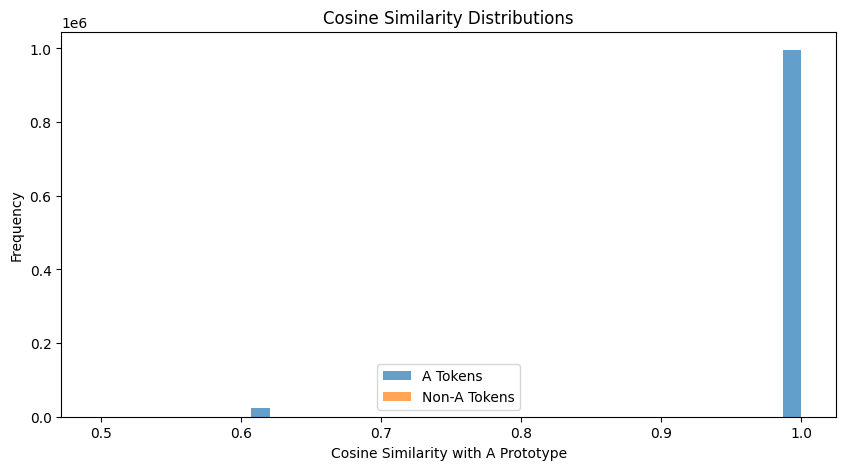

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

token_df_s01 = pd.concat([token_df_1k_s0, token_df_1k_s1])
ys = token_df_s01['token_annotations']
labels = ys.apply(lambda x: 1 if 'CMV enhancer' in x else 0)
mask = torch.tensor(labels.values, device=activations.device)

# Step 1: Separate A tokens and non-A tokens
A_tokens = activations[mask]      # shape (num_A, d)
nonA_tokens = activations[~mask]  # shape (num_nonA, d)

## First, move everything to CPU and numpy consistently
A_tokens_np = A_tokens.cpu().numpy()
nonA_tokens_np = nonA_tokens.cpu().numpy()

# Calculate mean
A_mean = np.mean(A_tokens_np, axis=0)

# Use a single normalization approach for everything
def normalize_vectors(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

# Normalize everything
A_tokens_norm = normalize_vectors(A_tokens_np)
nonA_tokens_norm = normalize_vectors(nonA_tokens_np)
A_mean_norm = A_mean / np.linalg.norm(A_mean)

# Then compute similarities
cos_sim_A = np.dot(A_tokens_norm, A_mean_norm)
cos_sim_nonA = np.dot(nonA_tokens_norm, A_mean_norm)

# Alternatively, you can use sklearn's cosine_similarity:
# cos_sim_A = cosine_similarity(A_tokens_norm, [A_mean_norm]).flatten()
# cos_sim_nonA = cosine_similarity(nonA_tokens_norm, [A_mean_norm]).flatten()

# Step 5: Analyze the resulting distributions
print("A tokens cosine similarity:")
print("Mean:", np.mean(cos_sim_A), "Std:", np.std(cos_sim_A))
print("\nNon-A tokens cosine similarity:")
print("Mean:", np.mean(cos_sim_nonA), "Std:", np.std(cos_sim_nonA))

# Step 6: Visualize by plotting histograms
plt.figure(figsize=(10, 5))

plt.hist(cos_sim_A, bins=30, alpha=0.7, label='A Tokens')
plt.hist(cos_sim_nonA, bins=30, alpha=0.7, label='Non-A Tokens')
plt.xlabel('Cosine Similarity with A Prototype')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distributions')
plt.legend()
plt.show()

In [ ]:
##

assert set(token_df_s01['seq_id']) == set(seq_ids)

In [ ]:
# Combine results, move to cpu before
all_acts = [x.cpu() for x in all_acts]
xs = torch.cat(all_acts, dim=0).cpu()

# conc token dfs
token_df_s01 = pd.concat([token_df_1k_s0, token_df_1k_s1])

# iterate over possible token annotations
annotations = list(token_df_s01['token_annotations'].value_counts().index)

# log results
results = []

for annotation in annotations[:120]:

    ## map to 1 if ys contains annotation, 0 otherwise
    annotation = str(annotation)
    if annotation == '[]': continue
    print(annotation)

    # Control: 1 create a dict that randomly maps each token in the vocab to 0 or 1
    #mapping = {token: np.random.randint(0, 2) for token in tokenizer_nt.get_vocab()}

    # based on this we create our labels
    #ys = token_df_s01['tokens'].apply(lambda x: mapping[x])

    ys = token_df_s01['token_annotations']
    ys = ys.apply(lambda x: 1 if annotation in x else 0)

    # check if there are any ys = 1, otherwise continue to next
    if ys.sum() == 0:
      print('No ys = 1, skipping')
      continue

    ## baserate acc
    freq_class = ys.value_counts()[1] / ys.value_counts().sum()
    br_acc = max(freq_class, 1-freq_class)
    print('Baserate accuracy:',br_acc)

    ## create Pytorch dataset from xs and ys to train logistic regression on
    x_tensor = xs.clone().detach().to(dtype=torch.float32)
    y_tensor = torch.tensor(ys.values, dtype=torch.float32)
    dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)

    ## split into train and val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    # do stratified splitting ensuring the ratio of classes is the same across ds
    from sklearn.model_selection import StratifiedShuffleSplit

    # Create stratified split indices
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(x_tensor, y_tensor))

    # Create datasets
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)


    ## create Pytorch dataloader from dataset to iterate over in batches
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=320*3, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=320*3, shuffle=False)


    # train linear regression

    import torch.nn as nn
    import torch.optim as optim
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # define model
    n_classes = 2
    model = nn.Linear(d_mlp, n_classes - 1)
    model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss() if n_classes == 2 else nn.CrossEntropyLoss()

    best_val_accuracy = 0.0
    best_val_f1 = 0.0

    num_epochs = 6
    for epoch in range(num_epochs):


        ### Pt 1 TRAINING PROBE

        model.train()
        train_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs.cuda())
            loss = criterion(outputs.squeeze().cpu(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')


        ### Pt 2 VALIDATE PROBE


        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.cuda())
                loss = criterion(outputs.squeeze().cpu(), targets)
                val_loss += loss.item()
                preds = torch.round(torch.sigmoid(outputs))
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        val_loss /= len(val_loader)
        # Now calculate accuracy
        accuracy = accuracy_score(all_targets, all_preds)
        precision = precision_score(all_targets, all_preds)
        recall = recall_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds)

        if f1 > best_val_f1:
            best_val_f1 = f1
            best_val_accuracy = accuracy

        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    entry = {
      'annotation': annotation,
      'baserate_accuracy': br_acc,
      'best_accuracy': best_val_accuracy,
      'best_f1': best_val_f1,
    }
    results.append(entry)

    print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')


df_results = pd.DataFrame(results)
df_results.to_csv("/content/drive/MyDrive/SAEs_for_Genomics/annotation_evaluation_results.csv", index=False)

['special token: <pad>']
Baserate accuracy: 0.838898088272225
Epoch 1/6, Train Loss: 0.4300
Epoch 1/6, Val Loss: 0.4065, Accuracy: 0.8305, Precision: 0.4189, Recall: 0.1354, F1: 0.2047
Epoch 2/6, Train Loss: 0.3985
Epoch 2/6, Val Loss: 0.3916, Accuracy: 0.8369, Precision: 0.4770, Recall: 0.1273, F1: 0.2010
Epoch 3/6, Train Loss: 0.3873
Epoch 3/6, Val Loss: 0.3839, Accuracy: 0.8404, Precision: 0.5183, Recall: 0.1308, F1: 0.2089
Epoch 4/6, Train Loss: 0.3814
Epoch 4/6, Val Loss: 0.3794, Accuracy: 0.8419, Precision: 0.5445, Recall: 0.1122, F1: 0.1861
Epoch 5/6, Train Loss: 0.3789
Epoch 5/6, Val Loss: 0.3780, Accuracy: 0.8405, Precision: 0.5255, Recall: 0.1018, F1: 0.1706
Epoch 6/6, Train Loss: 0.3781
Epoch 6/6, Val Loss: 0.3772, Accuracy: 0.8403, Precision: 0.5202, Recall: 0.1130, F1: 0.1857
Best Validation Accuracy: 0.8404
['ori']
Baserate accuracy: 0.9639216317177298
Epoch 1/6, Train Loss: 0.2041
Epoch 1/6, Val Loss: 0.1765, Accuracy: 0.9602, Precision: 0.0804, Recall: 0.0098, F1: 0.017

### Control 1: random transformer weights

In [ ]:
from transformers import AutoConfig, AutoModelForMaskedLM

config = AutoConfig.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-250m-multi-species")
model_nt = AutoModelForMaskedLM.from_config(config)

The repository for InstaDeepAI/nucleotide-transformer-v2-250m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-250m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


### Control 2: random data

In [ ]:
# Train and evaluate on a random dataset of shape (50000, 512)
xs = torch.rand(50000, 512, dtype=torch.float32)
ys = torch.randint(0, 2, (50000,), dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xs, ys), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xs, ys), batch_size=32, shuffle=False)

### Control 3: random token labeling

In [ ]:
# lets create a random mapping from the token-vocab to {0,1}

mapping = {token: np.random.randint(0, 2) for token in tokenizer_nt.get_vocab()}

# based on this we create our labels
ys = token_df_1k_s0['tokens'].apply(lambda x: mapping[x])

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=320, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=320, shuffle=False)

## Train linear probe

In [ ]:
# train linear regression

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# define model
n_classes = 2
model = nn.Linear(512, n_classes - 1)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss() if n_classes == 2 else nn.CrossEntropyLoss()

best_val_accuracy = 0.0

num_epochs = 50
for epoch in range(num_epochs):


    ### Pt 1 TRAINING PROBE

    model.train()
    train_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.cuda())
        loss = criterion(outputs.squeeze().cpu(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')


    ### Pt 2 VALIDATE PROBE


    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs.cuda())
            loss = criterion(outputs.squeeze().cpu(), targets)
            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    val_loss /= len(val_loader)
    # Now calculate accuracy
    accuracy = accuracy_score(all_targets, all_preds)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy

    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')

Epoch 1/50, Train Loss: 0.0889


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Val Loss: 0.0827, Accuracy: 0.9839, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2/50, Train Loss: 0.0818


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50, Val Loss: 0.0815, Accuracy: 0.9839, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 3/50, Train Loss: 0.0813


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/50, Val Loss: 0.0827, Accuracy: 0.9839, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 4/50, Train Loss: 0.0814
Epoch 4/50, Val Loss: 0.0821, Accuracy: 0.9837, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 5/50, Train Loss: 0.0813
Epoch 5/50, Val Loss: 0.0818, Accuracy: 0.9838, Precision: 0.2500, Recall: 0.0012, F1: 0.0024
Epoch 6/50, Train Loss: 0.0814


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/50, Val Loss: 0.0810, Accuracy: 0.9839, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 7/50, Train Loss: 0.0811


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/50, Val Loss: 0.0812, Accuracy: 0.9839, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


KeyboardInterrupt: 

## Analyse linear probe weights ~ SAE decoder weights

In [ ]:
linear_probe_weights = model.weight.cpu().detach().numpy()
sae_encoder_weights = sae_model.W_enc.cpu().detach().numpy()
sae_decoder_weights = sae_model.W_dec.cpu().detach().numpy()

# Dot products
dot_products_enc = linear_probe_weights @ sae_encoder_weights
# now dot products with decoder weights
dot_products_decoder = linear_probe_weights @ sae_decoder_weights.T

# Compute L2 norms
linear_probe_norms = np.linalg.norm(linear_probe_weights, axis=1, keepdims=True)  # Keep dims for broadcasting
encoder_norms = np.linalg.norm(sae_encoder_weights, axis=0, keepdims=True)  # Keep dims for broadcasting
decoder_norms = np.linalg.norm(sae_decoder_weights.T, axis=0, keepdims=True)  # Keep dims for broadcasting

# Cosine similarities
cosine_sims_enc = dot_products_enc / (linear_probe_norms @ encoder_norms)
cosine_sims_decoder = dot_products_decoder / (linear_probe_norms @ decoder_norms)


print("\nMax cosine similarity:", cosine_sims_enc.max())
print("Min cosine similarity:", cosine_sims_enc.min())
print("Mean absolute cosine similarity:", np.abs(cosine_sims_enc).mean())

print("\nMax cosine similarity:", cosine_sims_decoder.max())
print("Min cosine similarity:", cosine_sims_decoder.min())
print("Mean absolute cosine similarity:", np.abs(cosine_sims_decoder).mean())

In [ ]:
import plotly.express as px

# Create labels for x-axis
num_sae_units = dot_products_enc.shape[1]
x_labels = [f'SAE Unit {i}' for i in range(num_sae_units)]

# 1. Histogram
fig_hist = px.histogram(
    x=np.repeat(x_labels, dot_products_decoder.shape[0]),
    y=cosine_sims_decoder.flatten(),
    title='Distribution of Cosine Similarities for each SAE Unit',
    labels={'x': 'SAE Decoder Units', 'y': 'Cosine Similarity'},
    nbins=50
)

fig_hist.update_layout(
    showlegend=False,
    width=1000,
    height=600
)


fig_hist.show()


In [ ]:
# get max cosine_sim_enc value

max_cosine_sim_enc = cosine_sims_enc.max()
max_cosine_sim_decoder = cosine_sims_decoder.max()

# get index (sea latent) for each
max_cosine_sim_enc_idx = np.argmax(cosine_sims_enc)
max_cosine_sim_decoder_idx = np.argmax(cosine_sims_decoder)

print("Max cosine similarity:", max_cosine_sim_enc)
print("Max cosine similarity decoder:", max_cosine_sim_decoder)
print("Max cosine similarity index:", max_cosine_sim_enc_idx)
print("Max cosine similarity index decoder:", max_cosine_sim_decoder_idx)

In [ ]:
def predict_next_tokens(sequence, model, tokenizer, top_k=5, mask_token=None):
    """
    Predict the most likely next/masked tokens for a given nucleotide sequence.

    Args:
        sequence (str): Input nucleotide sequence
        model: The loaded transformer model
        tokenizer: The loaded tokenizer
        top_k (int): Number of top predictions to return
        mask_token (str, optional): If provided, will predict for masked position instead of next token

    Returns:
        list: Top k predictions with their probabilities
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        # If mask_token provided, insert it into sequence
        if mask_token:
            if mask_token not in sequence:
                raise ValueError("Mask token not found in sequence")
            input_sequence = sequence
        else:
            # For next token prediction, add mask to end
            input_sequence = sequence + tokenizer.mask_token

        # Tokenize input
        inputs = tokenizer(input_sequence, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get model predictions
        outputs = model(**inputs)
        predictions = outputs.logits

        # Find mask token position
        mask_position = (inputs['input_ids'] == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

        if len(mask_position) == 0:
            raise ValueError("No mask token found in processed sequence")

        # Get probabilities for masked position
        mask_position = mask_position[-1].item()  # Take last mask if multiple
        probs = torch.nn.functional.softmax(predictions[0, mask_position], dim=-1)

        # Get top k predictions
        top_k_probs, top_k_indices = torch.topk(probs, top_k)

        # Convert to tokens and probabilities
        results = []
        for prob, idx in zip(top_k_probs.cpu().numpy(), top_k_indices.cpu().numpy()):
            token = tokenizer.decode([idx]).strip()
            results.append((token, float(prob)))

    return results

# Example usage
def print_predictions(sequence, model=model_nt, tokenizer=tokenizer_nt, top_k=5, mask_token=None):
    """Helper function to print predictions in a readable format"""
    print(f"\nInput sequence: {sequence}")
    predictions = predict_next_tokens(sequence, model, tokenizer, top_k, mask_token)
    print("\nTop predictions:")
    for i, (token, prob) in enumerate(predictions, 1):
        print(f"{i}. Token: '{token}' - Probability: {prob:.4f}")


# For next token prediction
sequence = seq[9]
print_predictions(sequence, top_k=10)
